Ideally, we want to have a true external test set, that was not included in the data from OPERA and the paper from Naef & Acree. We migt be able to get one, but this is not certain. Therefore, we create a set here that will be excluded from any furhter analysis, that we can use as test set in case we do not find anything else.

In [1]:
#find all conf_ids that are NOT in cs_mdfps_schema.confid_data;
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = conn.cursor()

In [2]:
query = """

SELECT 
    e.molregno,
    c.conf_id,
    e.vp_log10_pa,
    m.mdfp,
    c.molblock,
    m.md_experiment_uuid,
    cd.confgen_uuid -- Add this column for confgen_uuid
FROM 
    cs_mdfps_schema.experimental_data e
JOIN 
    conformers c ON e.molregno = c.molregno
LEFT JOIN 
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
LEFT JOIN 
    cs_mdfps_schema.confid_data cd ON c.conf_id = cd.conf_id; -- Join with confid_data for confgen_uuid


"""

cur.execute(query)
data = cur.fetchall()
import pandas as pd

df = pd.DataFrame(data, columns=['molregno', 'conf_id', 'vp_log10_pa', 'mdfp', 'molblock', 'md_experiment_uuid', 'confgen_uuid'])
df

df = df[df['md_experiment_uuid'] != '80b643c8-5bdc-4b63-a12d-6f1ba3f7dd2a']
df = df[df['confgen_uuid'] != '11093a30-b6d0-4e3f-a22b-8dcad60d6a11']
df = df.dropna(subset=['mdfp'])


In [3]:
#query: count number of datapoint in table experimental_data
query = """
SELECT
    count(*)
FROM
    cs_mdfps_schema.experimental_data;
"""
cur.execute(query)
n_datapoints = cur.fetchall()
print("Number of datapoints in table experimental_data: ", n_datapoints[0][0])

Number of datapoints in table experimental_data:  3356


In [4]:
from rdkit import Chem
df['ROMol'] = df['molblock'].apply(Chem.MolFromMolBlock)
df['smiles'] = df['ROMol'].apply(Chem.MolToSmiles)
df = df[~df['smiles'].str.contains('B|Si|As|Se')]


In [5]:
#save
df.to_csv('cs_mdfps_schema_experimental_data.csv', index=False)

In [6]:
#add descriptors and save the csvs
#get the molblocks, get mols, calculcate PhysChem Descriptors, add to df
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
import json
df['mdfp_vec'] = df['mdfp'].apply(lambda val: json.loads(val['mdfp']) if (val and 'mdfp' in val) else None)
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
                     'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']

# Assuming 'mdfp_vec' is the column containing the lists
df[mdfp_features_all] = pd.DataFrame(df['mdfp_vec'].apply(lambda x: x if x is not None else pd.Series(dtype=float)).to_list(), index=df.index)
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='molblock')
df['descriptors'] = df['ROMol'].apply(Descriptors.CalcMolDescriptors)
df = pd.concat([df, pd.DataFrame(df['descriptors'].apply(lambda x: x if x is not None else {}).to_list(), index=df.index)], axis=1)

In [7]:
14/3356

0.004171632896305125

In [8]:
#note that some failed MD simulation because of parameterisation errors of e.g. compounds containing silicon
print(df['mdfp'].isnull().sum())
print(df['mdfp'].notnull().sum())

0
3050


In [9]:
#lets assign the vapor pressure to 10 population bins, each bin containing 10% of the data
df['population_bin'] = pd.qcut(df['vp_log10_pa'], 10, labels=False)
df['population_bin'] = df['population_bin'].astype('category')
df['population_bin'] = df['population_bin'].cat.rename_categories(range(1,11))
df['population_bin'] = df['population_bin'].astype('int')
df['population_bin'].value_counts() 

population_bin
1     305
2     305
10    305
8     305
9     305
4     305
7     305
3     305
5     305
6     305
Name: count, dtype: int64

In [10]:
#for each bin, print min and max vp_log10_pa
for i in range(1,11):
    min_value = round(df[df['population_bin'] == i]['vp_log10_pa'].min(), 1)
    max_value = round(df[df['population_bin'] == i]['vp_log10_pa'].max(), 1)
    total_range = round(max_value - min_value, 1)
    print('bin', i, 'min:', min_value, 'max:', max_value, 'total range:', total_range)


bin 1 min: -19.4 max: -4.4 total range: 15.0
bin 2 min: -4.4 max: -2.9 total range: 1.5
bin 3 min: -2.9 max: -1.4 total range: 1.5
bin 4 min: -1.4 max: -0.0 total range: 1.4
bin 5 min: -0.0 max: 1.1 total range: 1.1
bin 6 min: 1.1 max: 1.9 total range: 0.8
bin 7 min: 1.9 max: 2.7 total range: 0.8
bin 8 min: 2.7 max: 3.4 total range: 0.7
bin 9 min: 3.4 max: 4.2 total range: 0.8
bin 10 min: 4.2 max: 7.8 total range: 3.6


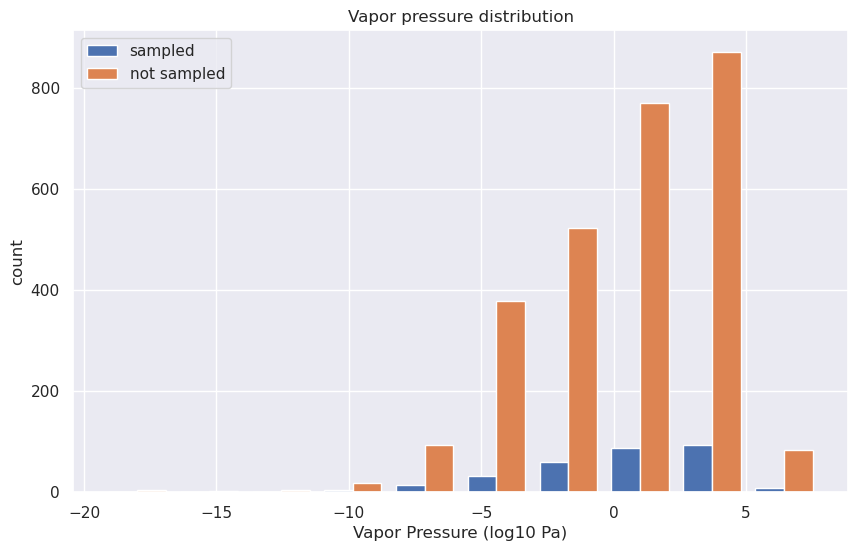

300 2750


In [11]:
#sample 10% from each bin
df_sample = pd.DataFrame()
for i in range(1,11):
    df_sample = pd.concat([df_sample,df[df['population_bin'] == i].sample(frac=0.1)])
df_not_sampled = df[~df.index.isin(df_sample.index)]
#histograms, using hist([sampled,no_sampled], bins=10)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 6))
plt.hist([df_sample['vp_log10_pa'], df_not_sampled['vp_log10_pa']], bins=10, label=['sampled', 'not sampled'])
plt.legend(loc='upper left')
plt.title('Vapor pressure distribution')
plt.xlabel('Vapor Pressure (log10 Pa)')
plt.ylabel('count')
plt.show()
print(len(df_sample), len(df_not_sampled))

For the rest, we want to do 10x a random split, comparing the following models:
1. XGBOOST (PhysChem)
2. XGBOOST (MDFP+)
3. XGBOOST (PhysChem + MDFP)
4. Attentive FP ('standard' graph)
5. Attentive FP (graph incl DASHPROPS)

Then, we have to do a few evaluations:
1. General performance
2. Look if there is a subset on which PhysChem does not work well
3. Look if there is a subset on which MDFP+ outperforms PhysChem

In [12]:
#save the dfs, then split and save the splits
df_sample.to_csv('OPERA_Naef_Stratified_Test.csv', index=False)
df_not_sampled.to_csv('OPERA_Naef_Training.csv', index=False)

from sklearn.model_selection import train_test_split
for i in range(10):
    df_train, df_val = train_test_split(df_not_sampled, test_size=0.2, random_state=42+i)
    df_train = df_train.drop(columns=['NumRotatableBonds'])
    df_train['NumRotatableBonds'] = df_train['ROMol'].apply(Descriptors.NumRotatableBonds)
    df_val = df_val.drop(columns=['NumRotatableBonds'])
    df_val['NumRotatableBonds'] = df_val['ROMol'].apply(Descriptors.NumRotatableBonds)
    df_train.to_csv('splits/OPERA_Naef_Training_'+str(i)+'.csv', index=False)
    df_val.to_csv('splits/OPERA_Naef_Validation_'+str(i)+'.csv', index=False)
    print(len(df_train), len(df_val))

2200 550
2200 550
2200 550
2200 550
2200 550
2200 550
2200 550
2200 550
2200 550
2200 550


In [16]:
#first experiment: XGBoost PhysicalChem Descriptors
import xgboost as xgb
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def XGBOOST_random_splits(params, descriptors,):
    pred_list,ys_list,molregnos = [],[],[]
    for i in range(10):
        df_train = pd.read_csv('splits/OPERA_Naef_Training_'+str(i)+'.csv')
        df_val = pd.read_csv('splits/OPERA_Naef_Validation_'+str(i)+'.csv')
        #if descriptor is ECFP4, split the mdfp_vec into 1024 columns
        if descriptors == 'ECFP4':
            df_val = df_val.join(pd.DataFrame(df_val['ECFP4'].to_list(), columns=[f'ECFP4_{i}' for i in range(1024)]))
            df_train = df_train.join(pd.DataFrame(df_train['ECFP4'].to_list(), columns=[f'ECFP4_{i}' for i in range(1024)]))
            descriptors = [f'ECFP4_{i}' for i in range(1024)]

        train_X = df_train[descriptors]
        train_y = df_train['vp_log10_pa']
        val_X = df_val[descriptors]
        val_y = df_val['vp_log10_pa']
        dtrain = xgb.DMatrix(train_X, label=train_y)
        dval = xgb.DMatrix(val_X, label=val_y)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )
        preds = model.predict(dval)
        rmse = mean_squared_error(val_y, preds, squared=False)
        pred_list.append(preds)
        ys_list.append(val_y)
        molregnos.append(df_val['molregno'])
        print(f"Split {i + 1}: RMSE = {rmse}")
    return pred_list, ys_list, molregnos
  

In [21]:
params = { #hyperparameters optimized by Working Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
from rdkit.Chem import Descriptors
RDKit_feature_names = list(Descriptors.descList)
RDKit_feature_names = [i[0] for i in RDKit_feature_names]   
pred_list_xgboost_physchem, ys_list_xgboost_physchem, molregnos_xgboost_physchem = XGBOOST_random_splits(params, RDKit_feature_names)

Split 1: RMSE = 0.7836812724536251
Split 2: RMSE = 0.7850215898788516
Split 3: RMSE = 0.8035068280807065
Split 4: RMSE = 0.8398868642950832
Split 5: RMSE = 0.8178513150555903
Split 6: RMSE = 0.7800556142554531
Split 7: RMSE = 0.8465802994926203
Split 8: RMSE = 0.8389064121621426
Split 9: RMSE = 0.7703268564177125
Split 10: RMSE = 0.8174000594564026


In [22]:
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
                     'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus = XGBOOST_random_splits(params, mdfp_features_all)

Split 1: RMSE = 0.8179126715522688
Split 2: RMSE = 0.855459843743086
Split 3: RMSE = 0.852480210564891
Split 4: RMSE = 0.9779578022388736
Split 5: RMSE = 0.9392495559471412
Split 6: RMSE = 0.9919526010317234
Split 7: RMSE = 0.9362543164415533
Split 8: RMSE = 0.9410757959932815
Split 9: RMSE = 0.9018027543028057
Split 10: RMSE = 0.9302575243219328


In [23]:
mdfp_features_sim_only = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_and_physchem, ys_list_xgboost_mdfp_and_physchem, molregnos_xgboost_mdfp_and_physchem = XGBOOST_random_splits(params, mdfp_features_sim_only + list(RDKit_feature_names))

Split 1: RMSE = 0.739513594567825
Split 2: RMSE = 0.7981939620152302
Split 3: RMSE = 0.8378140911444665
Split 4: RMSE = 0.8890114918006972
Split 5: RMSE = 0.847353974684178
Split 6: RMSE = 0.8102400873477106
Split 7: RMSE = 0.813973836508607
Split 8: RMSE = 0.8221373015633604
Split 9: RMSE = 0.7789659515914691
Split 10: RMSE = 0.9022495147327904


In [24]:
features_2d_counts = [f for f in mdfp_features_all if f not in mdfp_features_sim_only]
pred_list_xgboost_mdfp_counts, ys_list_xgboost_mdfp_counts, molregnos_xgboost_mdfp_counts = XGBOOST_random_splits(params, features_2d_counts)

Split 1: RMSE = 1.245143098280475
Split 2: RMSE = 1.4393309664026461
Split 3: RMSE = 1.1930275080592934
Split 4: RMSE = 1.4122749419590357
Split 5: RMSE = 1.275771721949446
Split 6: RMSE = 1.5070007762962456
Split 7: RMSE = 1.4187777305834013
Split 8: RMSE = 1.369684408494091
Split 9: RMSE = 1.4282491642518154
Split 10: RMSE = 1.3652059418491738


In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, print_stats=True, bounds=None, title=None, print_spearman=False, name=None, dims = (1, 3)):
    # fig, axes = plt.subplots(1, len(reals_list), figsize=(10 * len(reals_list), 8))
    #assert that len(reals_list) is smaller then the number of subplots
    assert len(reals_list) <= dims[0]*dims[1]
    fig, axes = plt.subplots(dims[0], dims[1], figsize=(10 * dims[1], 8 * dims[0]))
    axes = axes.flatten()
    for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
        ax = axes[i] if len(reals_list) > 1 else axes


    # for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
    #     ax = axes[i] if len(reals_list) > 1 else axes

        rmses, maes, ebos, kts, median_aes = [], [], [], [], []

        for r, p in zip(reals, predictions):
            RMSE, MAE, EBO, KT, median_AE = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)
            median_aes.append(median_AE)

        rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
        rmse_mean = np.mean(rmses)
        mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
        median_AE_mean = np.mean(median_aes)

        mrn = [item for sublist in molregnos for item in sublist]
        real = [item for sublist in reals for item in sublist]
        prediction = [item for sublist in predictions for item in sublist]

        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()

        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')

        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")

        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]

        ax.axis([lower, upper, lower, upper])

        text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})',
                           transform=ax.transAxes, fontsize=12, verticalalignment='top',
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        if title is not None:
            ax.set_title(title[i] if len(reals_list) > 1 else title, fontsize=14)

        ax.set_aspect('equal', 'box')

    if name:
        plt.savefig(f'{name}.png', dpi=800, bbox_inches='tight')
    else:
        plt.show()


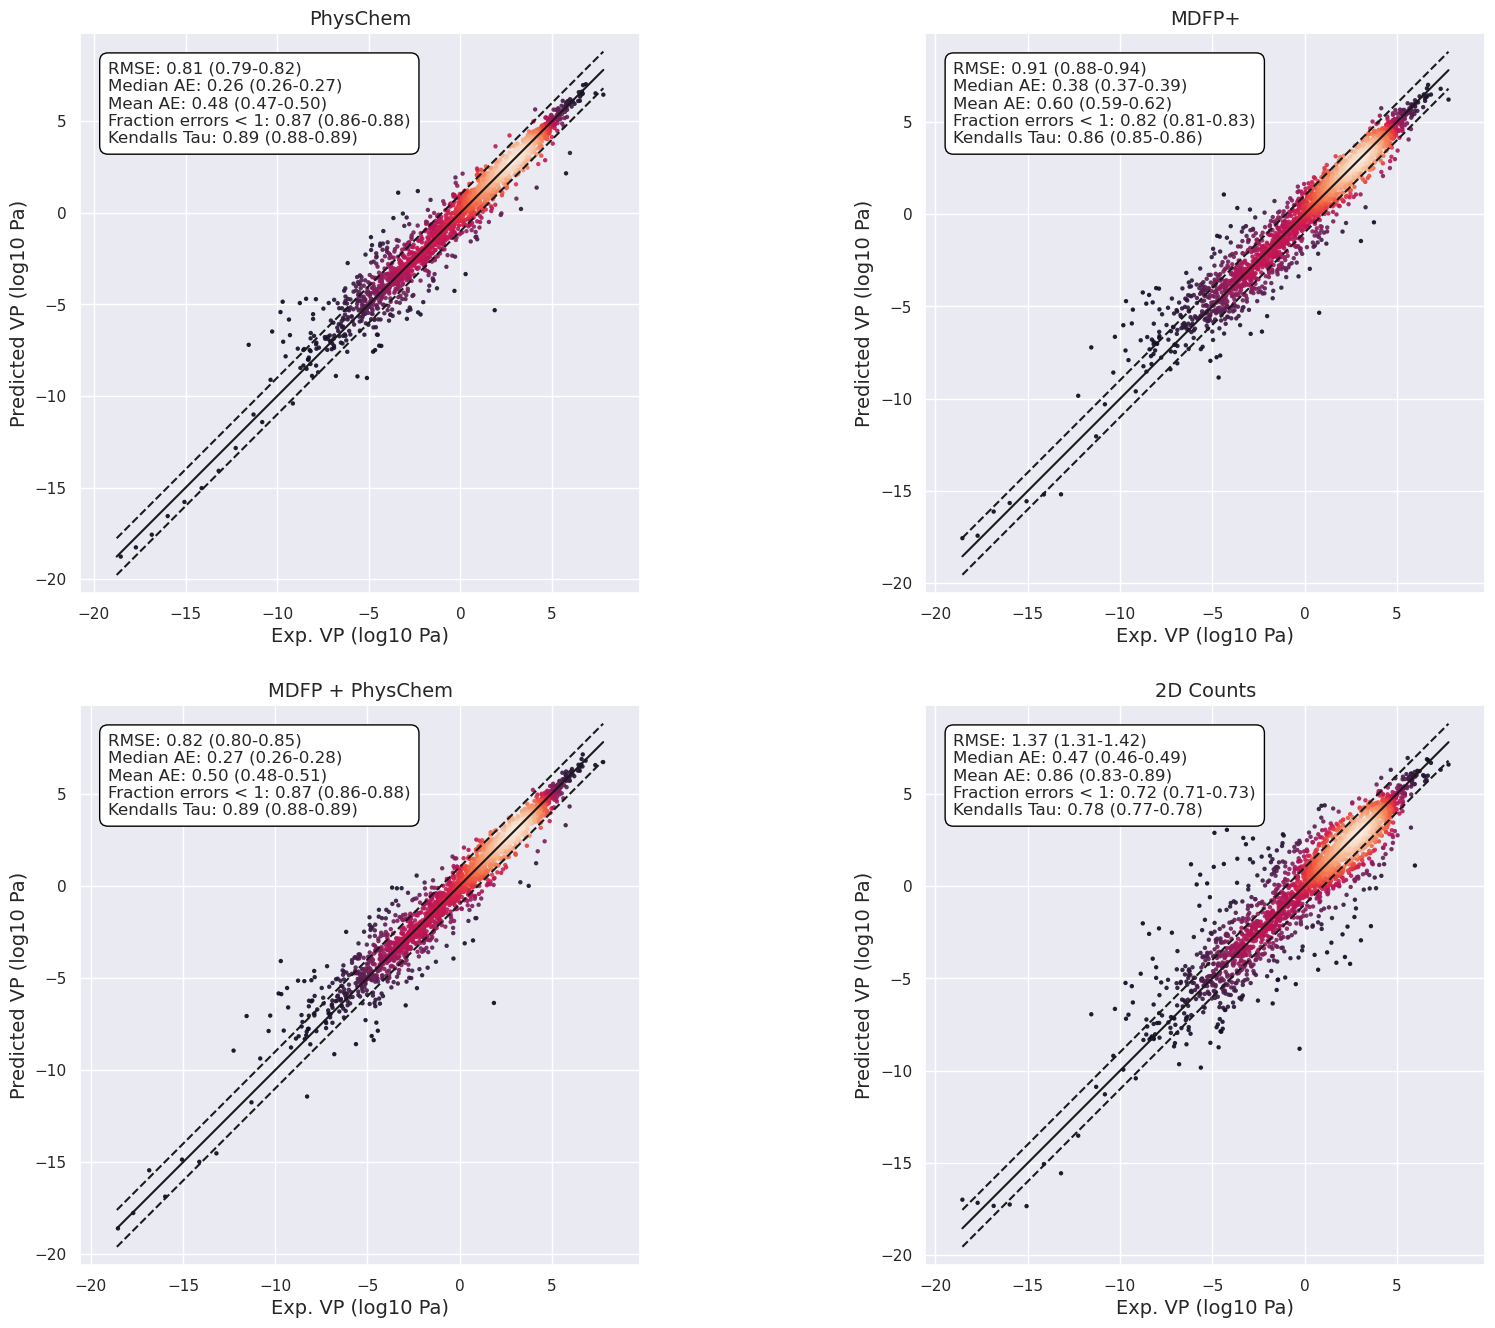

In [26]:
reals_list = [ys_list_xgboost_physchem, ys_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_and_physchem, ys_list_xgboost_mdfp_counts]
predictions_list = [pred_list_xgboost_physchem, pred_list_xgboost_mdfp_plus, pred_list_xgboost_mdfp_and_physchem, pred_list_xgboost_mdfp_counts]
molregnos_list = [molregnos_xgboost_physchem, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_counts]
title = ['PhysChem', 'MDFP+', 'MDFP + PhysChem', '2D Counts']
density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, title=title, name='XGBoost_MDFP_PhysChem_2DCounts', dims=(2,2))

In [28]:
#save these results in pickle files, store in splits
import pickle
data_xgboost_physchem = {'pred_list': pred_list_xgboost_physchem, 'ys_list': ys_list_xgboost_physchem, 'molregnos': molregnos_xgboost_physchem}
with open('splits/predictions/OPERA_Naef_XGBoost_PhysChem.pkl', 'wb') as f:
    pickle.dump(data_xgboost_physchem, f)
data_xgboost_mdfp_plus = {'pred_list': pred_list_xgboost_mdfp_plus, 'ys_list': ys_list_xgboost_mdfp_plus, 'molregnos': molregnos_xgboost_mdfp_plus}
with open('splits/predictions/OPERA_Naef_XGBoost_MDFP.pkl', 'wb') as f:
    pickle.dump(data_xgboost_mdfp_plus, f)
data_xgboost_mdfp_and_physchem = {'pred_list': pred_list_xgboost_mdfp_and_physchem, 'ys_list': ys_list_xgboost_mdfp_and_physchem, 'molregnos': molregnos_xgboost_mdfp_and_physchem}
with open('splits/predictions/OPERA_Naef_XGBoost_MDFP_PhysChem.pkl', 'wb') as f:
    pickle.dump(data_xgboost_mdfp_and_physchem, f)

In [29]:
#load data again from pickles
import pickle
with open('splits/predictions/OPERA_Naef_XGBoost_PhysChem.pkl', 'rb') as f:
    data_xgboost_physchem = pickle.load(f)
with open('splits/predictions/OPERA_Naef_XGBoost_MDFP.pkl', 'rb') as f:
    data_xgboost_mdfp_plus = pickle.load(f)
with open('splits/predictions/OPERA_Naef_XGBoost_MDFP_PhysChem.pkl', 'rb') as f:
    data_xgboost_mdfp_and_physchem = pickle.load(f)
pred_list_xgboost_physchem = data_xgboost_physchem['pred_list']
ys_list_xgboost_physchem = data_xgboost_physchem['ys_list']
molregnos_xgboost_physchem = data_xgboost_physchem['molregnos']
pred_list_xgboost_mdfp_plus = data_xgboost_mdfp_plus['pred_list']
ys_list_xgboost_mdfp_plus = data_xgboost_mdfp_plus['ys_list']
molregnos_xgboost_mdfp_plus = data_xgboost_mdfp_plus['molregnos']
pred_list_xgboost_mdfp_and_physchem = data_xgboost_mdfp_and_physchem['pred_list']
ys_list_xgboost_mdfp_and_physchem = data_xgboost_mdfp_and_physchem['ys_list']
molregnos_xgboost_mdfp_and_physchem = data_xgboost_mdfp_and_physchem['molregnos']


In [31]:
pred_list_xgboost_physchem_flat = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_list_xgboost_physchem_flat = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_xgboost_physchem_flat = [item for sublist in molregnos_xgboost_physchem for item in sublist]
df_results_xgboost_physchem = pd.DataFrame({'Pred_Physchem': pred_list_xgboost_physchem_flat, 'vp_log10_pa': ys_list_xgboost_physchem_flat, 'molregno': molregnos_xgboost_physchem_flat})
pred_list_xgboost_mdfp_plus_flat = [item for sublist in pred_list_xgboost_mdfp_plus for item in sublist]
ys_list_xgboost_mdfp_plus_flat = [item for sublist in ys_list_xgboost_mdfp_plus for item in sublist]
molregnos_xgboost_mdfp_plus_flat = [item for sublist in molregnos_xgboost_mdfp_plus for item in sublist]
df_results_xgboost_mdfp_plus = pd.DataFrame({'Pred_MDFP': pred_list_xgboost_mdfp_plus_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_flat, 'molregno': molregnos_xgboost_mdfp_plus_flat})
pred_list_xgboost_mdfp_and_physchem_flat = [item for sublist in pred_list_xgboost_mdfp_and_physchem for item in sublist]
ys_list_xgboost_mdfp_and_physchem_flat = [item for sublist in ys_list_xgboost_mdfp_and_physchem for item in sublist]
molregnos_xgboost_mdfp_and_physchem_flat = [item for sublist in molregnos_xgboost_mdfp_and_physchem for item in sublist]
df_results_xgboost_mdfp_and_physchem = pd.DataFrame({'Pred_MDFP_Physchem': pred_list_xgboost_mdfp_and_physchem_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_and_physchem_flat, 'molregno': molregnos_xgboost_mdfp_and_physchem_flat})
#combine into one df
df_results = pd.concat([df_results_xgboost_physchem, df_results_xgboost_mdfp_plus, df_results_xgboost_mdfp_and_physchem], axis=1)
df_results = df_results.loc[:,~df_results.columns.duplicated()]
#vp_log10_pa as float, all preds as floats
df_results['vp_log10_pa'] = df_results['vp_log10_pa'].astype(float)
df_results['Pred_Physchem'] = df_results['Pred_Physchem'].astype(float)
df_results['Pred_MDFP'] = df_results['Pred_MDFP'].astype(float)
df_results['Pred_MDFP_Physchem'] = df_results['Pred_MDFP_Physchem'].astype(float)
# #add column error PhysChem, error MDFP, error MDFP_PhysChem
df_results['error_PhysChem'] = df_results['vp_log10_pa'] - df_results['Pred_Physchem']
df_results['error_MDFP'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP']
df_results['error_MDFP_PhysChem'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP_Physchem']
df_results
#save
df_results.to_csv('splits/predictions/OPERA_Naef_XGBoost_PhysChem_MDFP_MDFP_PhysChem.csv', index=False)


In [28]:
cn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = cn.cursor()

In [29]:
df_results

,Pred_Physchem,vp_log10_pa,molregno,Pred_MDFP,Pred_MDFP_Physchem,error_PhysChem,error_MDFP,error_MDFP_PhysChem
0,0.370248,-0.176098,17139,0.392157,0.331275,-0.546346,-0.568255,-0.507373
1,-1.214461,-0.959000,15772,-3.017217,-1.740071,0.255461,2.058217,0.781071
2,2.350479,3.182503,315,3.748815,3.139736,0.832024,-0.566312,0.042767
3,-4.958812,-4.574099,948,-3.832858,-3.792629,0.384714,-0.741240,-0.781469
4,4.191795,3.368401,3705,2.854850,3.110881,-0.823394,0.513551,0.257520
...,...,...,...,...,...,...,...,...
5495,2.615578,2.840000,15959,3.136857,2.912081,0.224422,-0.296857,-0.072081
5496,2.376604,1.949000,16339,1.686961,1.985625,-0.427604,0.262039,-0.036625
5497,2.712019,2.962502,2941,3.809486,3.065394,0.250482,-0.846984,-0.102892
5498,1.549318,-0.260398,371,1.262549,1.790653,-1.809717,-1.522947,-2.051051


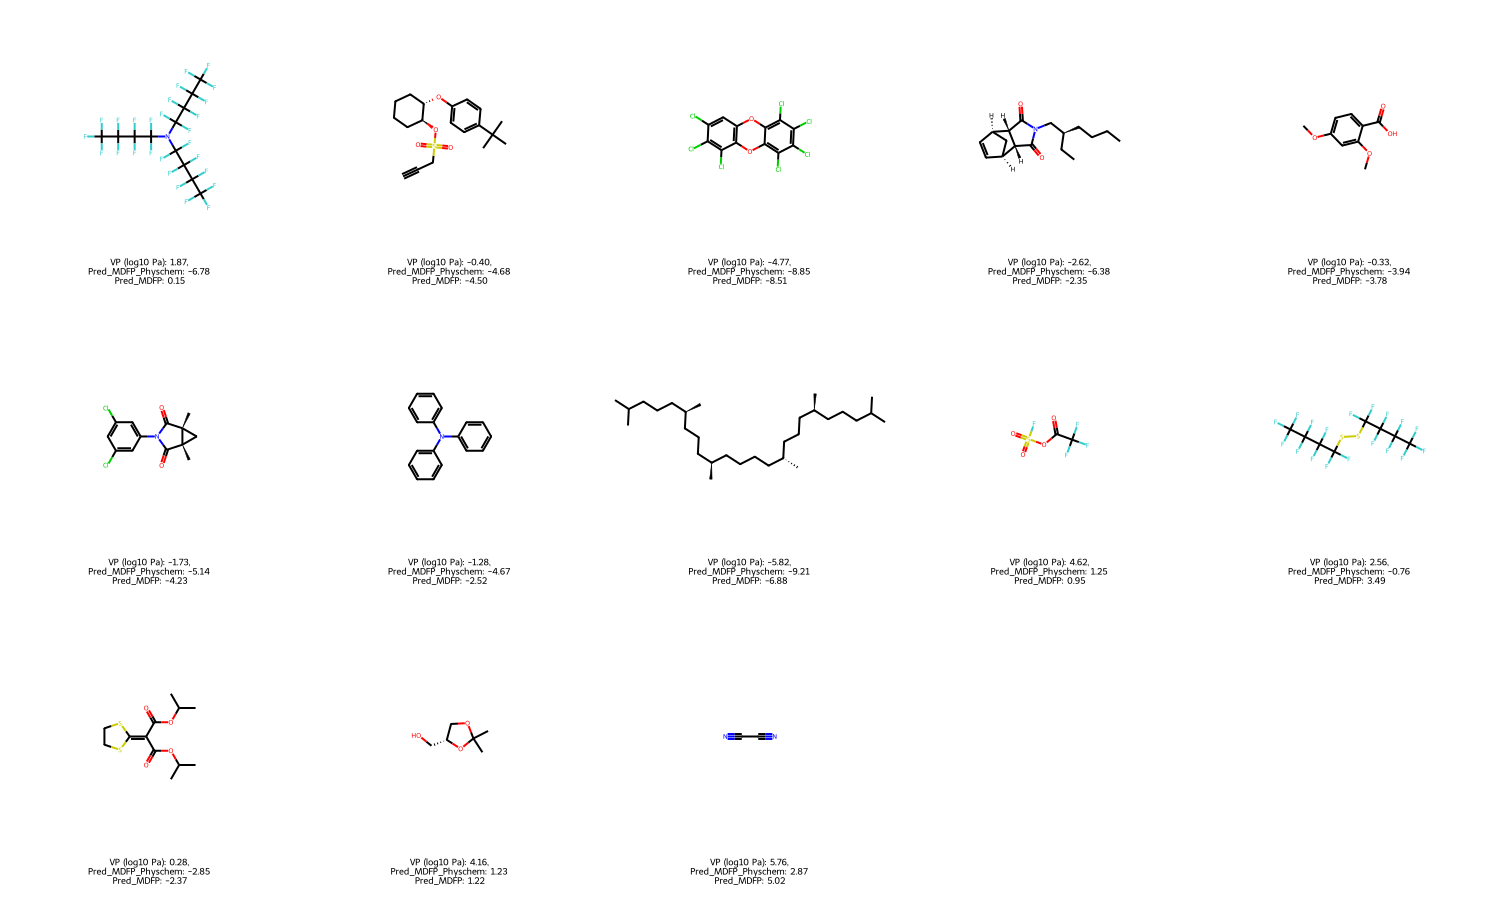

In [30]:
top10_molregnos = df_results.sort_values('error_MDFP_PhysChem', ascending=False).head(20)['molregno'].tolist()
#draw these
import os
from rdkit import Chem
from rdkit.Chem import Draw

#load the mols
query = """
SELECT
    molregno,
    molblock,
    conf_id
FROM
    conformers
WHERE
    molregno IN %s;
"""
cur.execute(query, (tuple(top10_molregnos),))
data = cur.fetchall()
df = pd.DataFrame(data, columns=['molregno', 'molblock', 'conf_id'])
#drop duplicate molregnos, keeping only lowest conf_id
df = df.sort_values('conf_id').drop_duplicates('molregno', keep='first')
#get molblocks
molblocks = df['molblock'].tolist()
mols = [Chem.MolFromMolBlock(m) for m in molblocks]
mols_2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
molregnos = df['molregno'].tolist()
#for these molregnos, get avg vp_log10_pa and avg Pred_MDFP_Physchem
vps, preds_PhysChem,preds_MDFP = [], [], []
for molregno in molregnos:
    vp = df_results[df_results['molregno'] == molregno]['vp_log10_pa'].mean()
    pred = df_results[df_results['molregno'] == molregno]['Pred_MDFP_Physchem'].mean()
    pred_mdfp = df_results[df_results['molregno'] == molregno]['Pred_MDFP'].mean()
    preds_PhysChem.append(pred)
    vps.append(vp)
    preds_MDFP.append(pred_mdfp)
#sort by biggest error
errors = [abs(vp - pred) for vp, pred in zip(vps, preds_PhysChem)]
#sort by biggest error
mols = [m for _, m in sorted(zip(errors, mols), reverse=True)]
mols_2d = [m for _, m in sorted(zip(errors, mols_2d), reverse=True)]
vps = [vp for _, vp in sorted(zip(errors, vps), reverse=True)]
preds = [pred for _, pred in sorted(zip(errors, preds_PhysChem), reverse=True)]
preds_mdfp = [pred for _, pred in sorted(zip(errors, preds_MDFP), reverse=True)]

img = Draw.MolsToGridImage(mols_2d, molsPerRow=5, subImgSize=(300, 300), legends=[f'VP (log10 Pa): {vp:.2f}, \nPred_MDFP_Physchem: {pred:.2f} \nPred_MDFP: {pred_mdfp:.2f}' for vp, pred, pred_mdfp in zip(vps, preds, preds_mdfp)])
img


In [31]:
#get 50 worst molregnos from PhysChem (highest error)
df_results['error_PhysChem'] = abs(df_results['error_PhysChem'])
df_results['error_MDFP'] = abs(df_results['error_MDFP'])
df_results['error_MDFP_PhysChem'] = abs(df_results['error_MDFP_PhysChem'])
molregnos_worst_physchem = df_results.sort_values('error_PhysChem', ascending=False).head(50)['molregno'].tolist()

In [32]:
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = conn.cursor()

In [33]:
#get the molblocks for these molregnos, for confids that have an mdfp
query = """
SELECT
    c.molregno,
    c.conf_id,
    c.molblock
FROM
    conformers c
JOIN
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
WHERE
    c.molregno IN %s;
"""
cur.execute(query, (tuple(molregnos_worst_physchem),))
data = cur.fetchall()

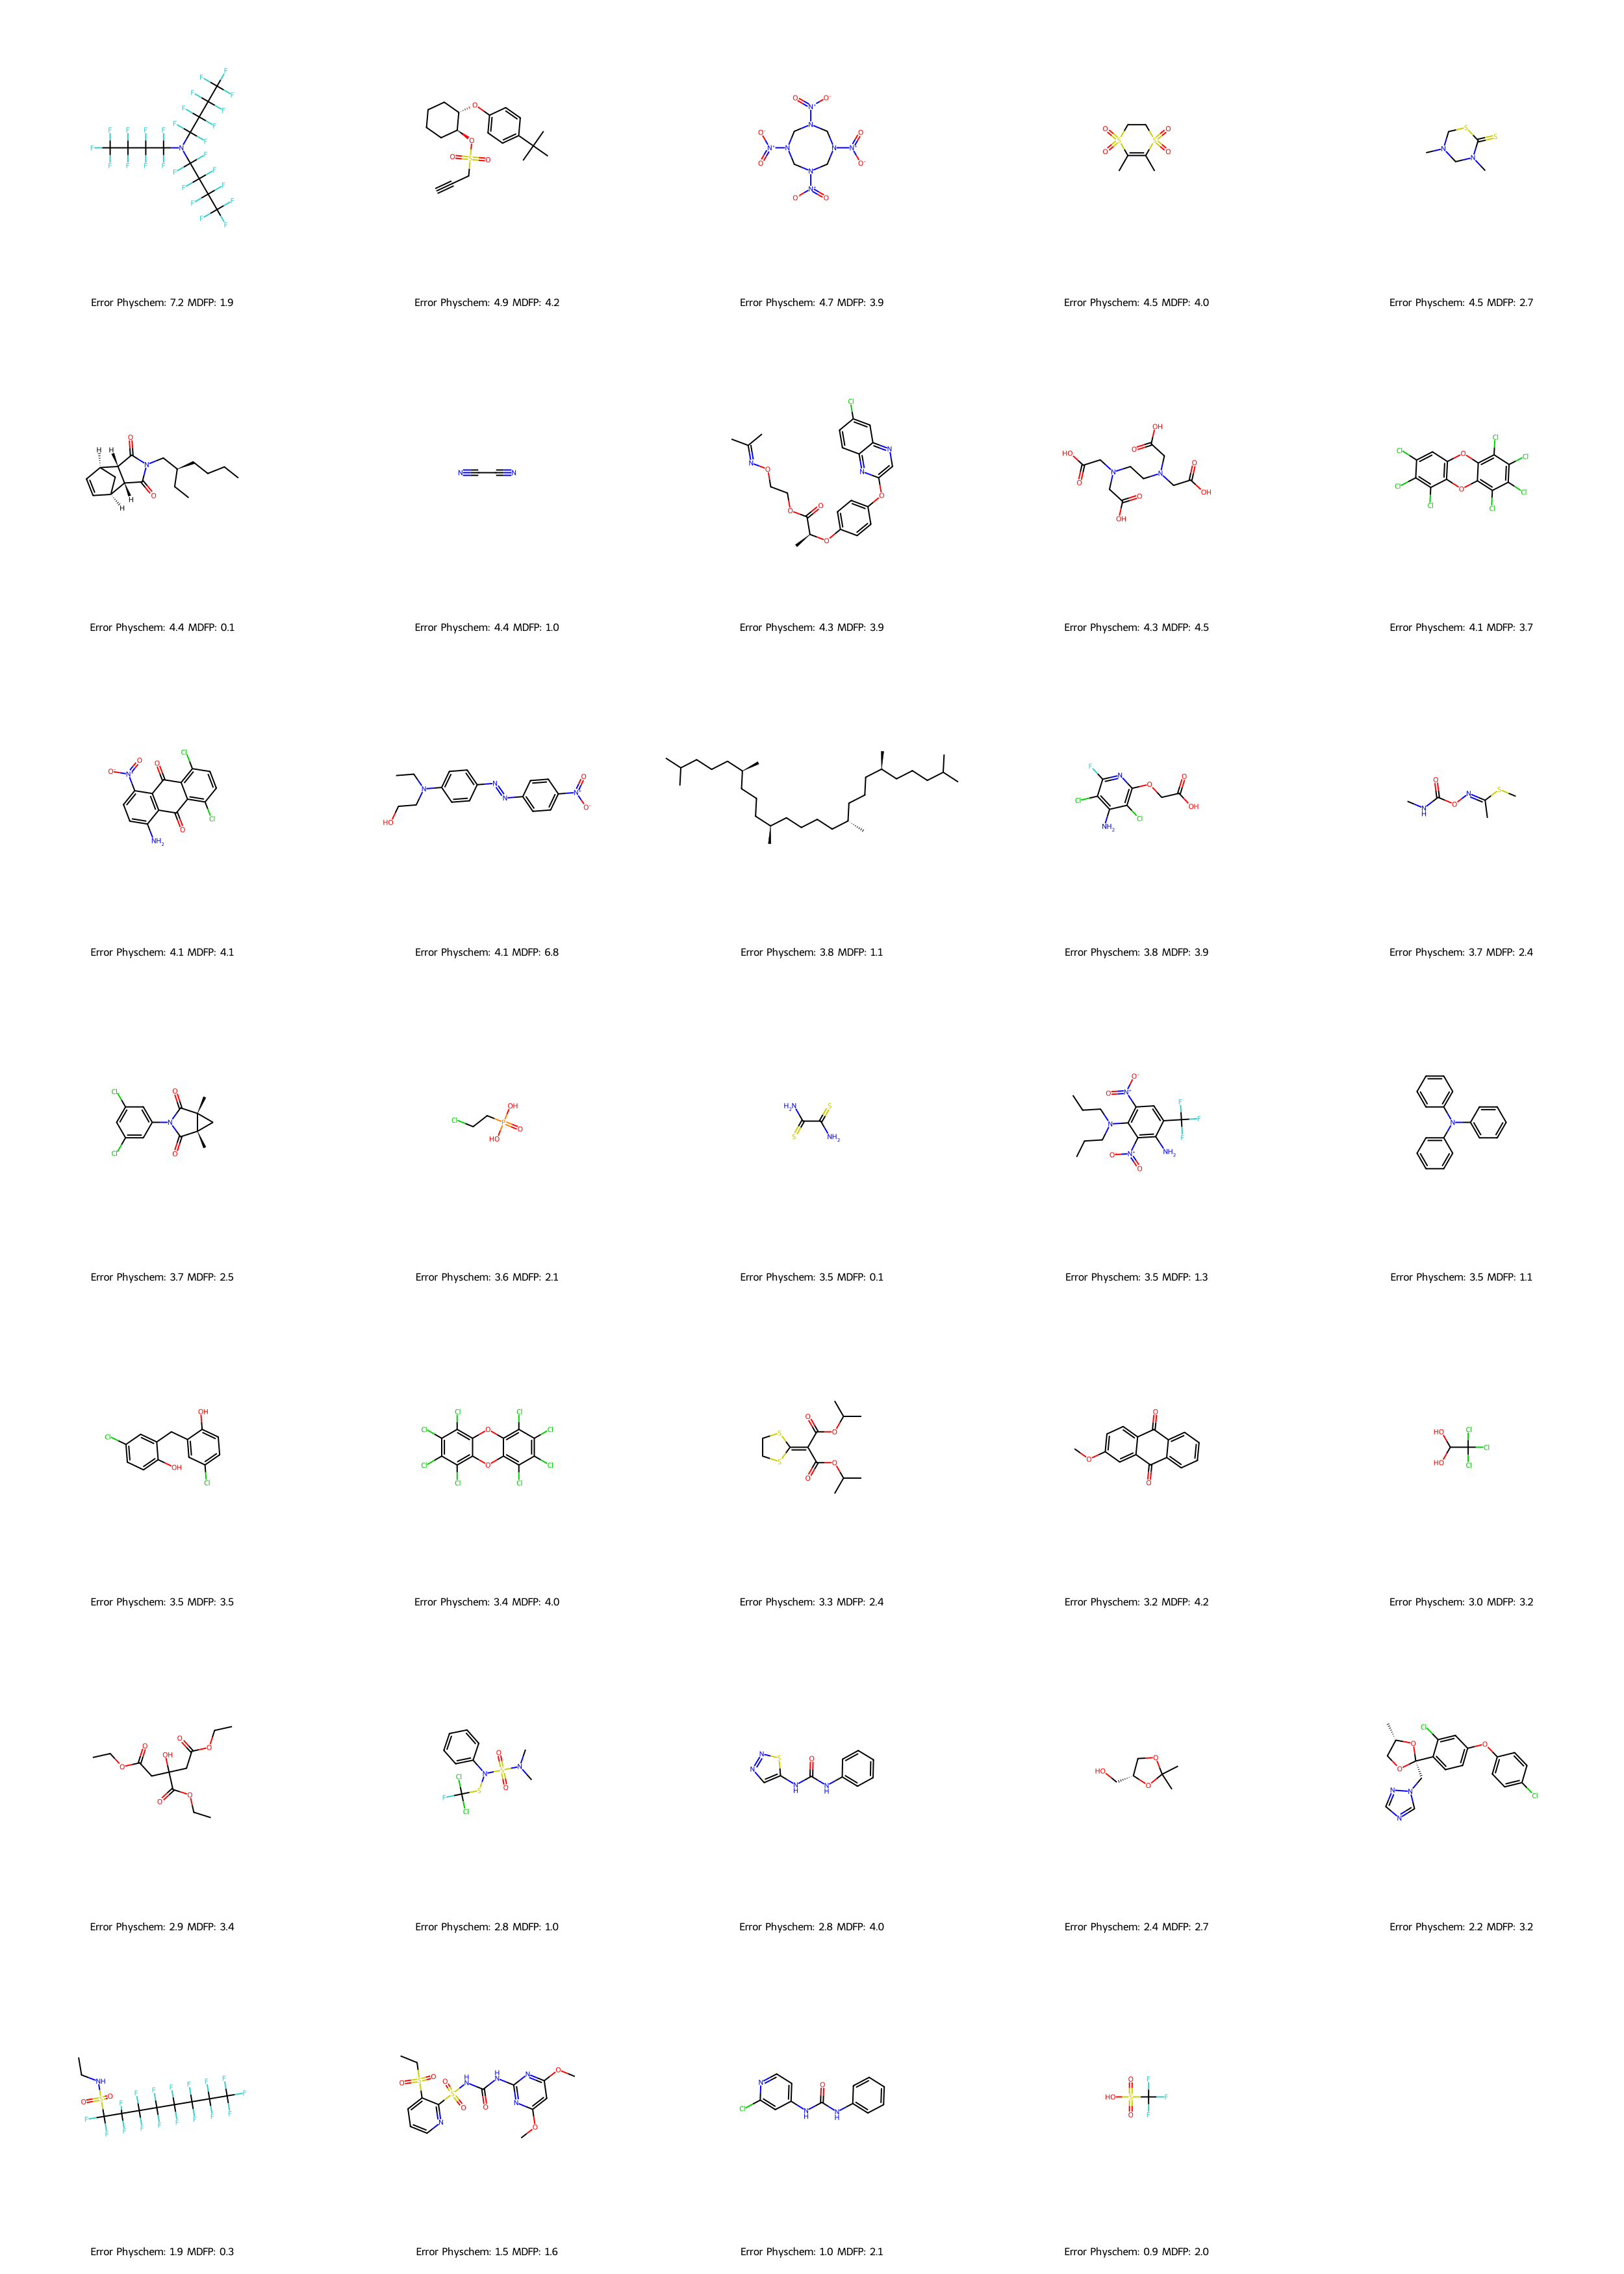

In [34]:
df_worst_physchem = pd.DataFrame(data, columns=['molregno', 'conf_id', 'molblock'])
df_worst_physchem = df_worst_physchem.sort_values('conf_id').drop_duplicates('molregno', keep='first')
mols = [Chem.MolFromMolBlock(molblock) for molblock in df_worst_physchem['molblock']]
mols = [m for m in mols if m is not None]
mols_2D = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
molregnos = df_worst_physchem['molregno'].tolist()
#also get the errors for thes molregnos
errors = []
errors_mdfp = []
for molregno in molregnos:
    errors.append(df_results[df_results['molregno'] == molregno]['error_PhysChem'].values[0])
    errors_mdfp.append(df_results[df_results['molregno'] == molregno]['error_MDFP'].values[0])

#sort mols by error, highest first
mols_2D = [x for _, x in sorted(zip(errors, mols_2D), key=lambda pair: pair[0], reverse=True)]
errors_mdfp = [x for _, x in sorted(zip(errors, errors_mdfp), key=lambda pair: pair[0], reverse=True)]
errors_mdfp = [round(e, 1) for e in errors_mdfp]
errors = sorted(errors, reverse=True)
errors = [round(e, 1) for e in errors]
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mols_2D, molsPerRow=5, subImgSize=(500, 500), legends=[f'Error Physchem: {e} MDFP: {e_mdfp}' for e, e_mdfp in zip(errors, errors_mdfp)])
img

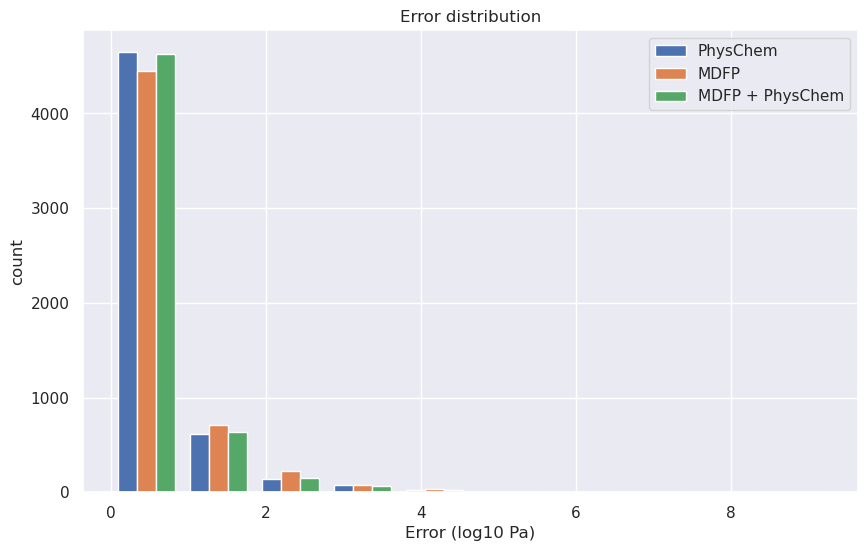

In [35]:
#plot the error distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10, 6))
plt.hist([df_results['error_PhysChem'].tolist(), df_results['error_MDFP'].tolist(), df_results['error_MDFP_PhysChem'].tolist()], bins=10, label=['PhysChem', 'MDFP', 'MDFP + PhysChem'])
plt.legend(loc='upper right')
plt.title('Error distribution')
plt.xlabel('Error (log10 Pa)')
plt.ylabel('count')
plt.show()

In [36]:
#for each molregno, check if average error is higher for PhysChem or MDFP
molregnos_unique = df_results['molregno'].unique()
physchem_better_counter = mdfp_better_counter  = 0
errors_physchem_list, errors_mdfp_list = [], []
for mrno in molregnos_unique:
    error_physchem = df_results[df_results['molregno'] == mrno]['error_PhysChem'].max()
    error_mdfp = df_results[df_results['molregno'] == mrno]['error_MDFP'].max()
    errors_physchem_list.append(error_physchem)
    errors_mdfp_list.append(error_mdfp)
    if error_physchem > error_mdfp:
        physchem_better_counter += 1
    elif error_mdfp > error_physchem:
        mdfp_better_counter += 1
    else:
        print('equal error')
print('PhysChem better:', physchem_better_counter, 'MDFP better:', mdfp_better_counter)

PhysChem better: 971 MDFP better: 1494


In [37]:
df_results
#for each molregno, find which method has the lowest error
df_results['error_PhysChem'] = abs(df_results['error_PhysChem'])
df_results['error_MDFP'] = abs(df_results['error_MDFP'])
df_results['error_MDFP_PhysChem'] = abs(df_results['error_MDFP_PhysChem'])
df_results['error_PhysChem'] = df_results['error_PhysChem'].astype(float)
df_results['error_MDFP'] = df_results['error_MDFP'].astype(float)
df_results['error_MDFP_PhysChem'] = df_results['error_MDFP_PhysChem'].astype(float)
df_results['min_error'] = df_results[['error_PhysChem', 'error_MDFP', 'error_MDFP_PhysChem']].idxmin(axis=1)
df_results['min_error'] = df_results['min_error'].apply(lambda x: x.split('_')[1])
df_results['min_error'].value_counts()

min_error
MDFP        3463
PhysChem    2037
Name: count, dtype: int64

In [38]:
lowest_err_mdfp = lowest_err_physchem  = 0
for molregno in df_results['molregno'].unique():
    #get avg error for each method
    error_physchem = df_results[df_results['molregno'] == molregno]['error_PhysChem'].mean()
    error_mdfp = df_results[df_results['molregno'] == molregno]['error_MDFP'].mean()
    #find which one is the lowest
    min_error = min(error_physchem, error_mdfp)
    if min_error == error_physchem:
        lowest_err_physchem += 1
    elif min_error == error_mdfp:
        lowest_err_mdfp += 1
    else:
        print('error')
print('PhysChem:', lowest_err_physchem, 'MDFP:', lowest_err_mdfp)
    

PhysChem: 1497 MDFP: 968


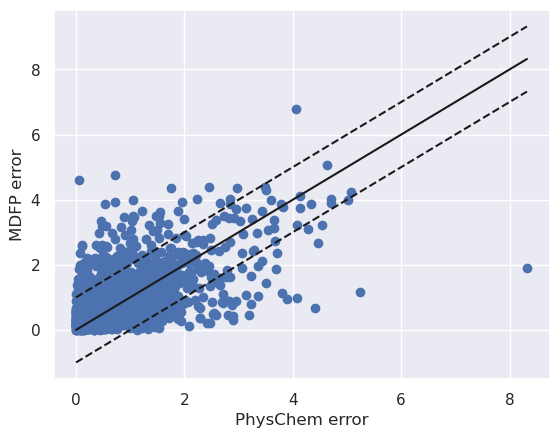

In [39]:
#scatter of errors against each other, with diagonal line, plus +- 1
fig, ax = plt.subplots()
ax.scatter(errors_physchem_list, errors_mdfp_list)
ax.plot([min(errors_physchem_list + errors_mdfp_list), max(errors_physchem_list + errors_mdfp_list)], [min(errors_physchem_list + errors_mdfp_list), max(errors_physchem_list + errors_mdfp_list)], 'k-')
ax.plot([min(errors_physchem_list + errors_mdfp_list), max(errors_physchem_list + errors_mdfp_list)], [min(errors_physchem_list + errors_mdfp_list) - 1, max(errors_physchem_list + errors_mdfp_list) - 1], 'k--')
ax.plot([min(errors_physchem_list + errors_mdfp_list), max(errors_physchem_list + errors_mdfp_list)], [min(errors_physchem_list + errors_mdfp_list) + 1, max(errors_physchem_list + errors_mdfp_list) + 1], 'k--')
ax.set_xlabel('PhysChem error')
ax.set_ylabel('MDFP error')
plt.show()

best_method
MDFP_PhysChem    1241
PhysChem          903
MDFP              321
Name: count, dtype: int64


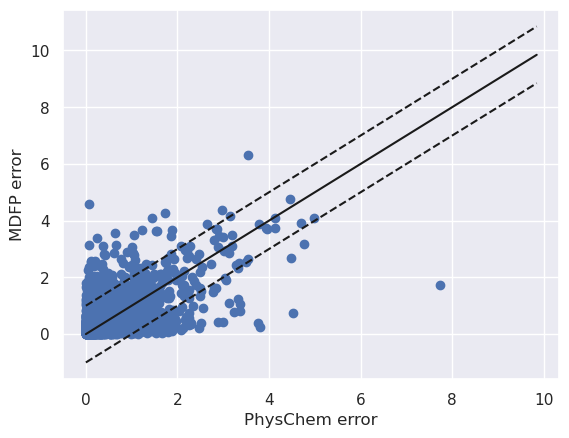

In [40]:
df_results_avg = pd.concat([df_results_xgboost_physchem, df_results_xgboost_mdfp_plus, df_results_xgboost_mdfp_and_physchem], axis=1)
df_results_avg = df_results_avg.loc[:,~df_results_avg.columns.duplicated()]
#average over molregnos
df_results_avg = df_results_avg.groupby('molregno').mean()
df_results_avg['error_PhysChem'] = abs(df_results_avg['vp_log10_pa'] - df_results_avg['Pred_Physchem'])
df_results_avg['error_MDFP'] = abs(df_results_avg['vp_log10_pa'] - df_results_avg['Pred_MDFP'])
df_results_avg['error_MDFP_PhysChem'] = abs(df_results_avg['vp_log10_pa'] - df_results_avg['Pred_MDFP_Physchem'])

#add column: best method, based on lowest error
df_results_avg['best_method'] = 'PhysChem'
df_results_avg.loc[df_results_avg['error_MDFP'] < df_results_avg['error_PhysChem'], 'best_method'] = 'MDFP'
df_results_avg.loc[df_results_avg['error_MDFP_PhysChem'] < df_results_avg['error_PhysChem'], 'best_method'] = 'MDFP_PhysChem'
print(df_results_avg['best_method'].value_counts())
fig, ax = plt.subplots()
ax.scatter(df_results_avg['error_PhysChem'], df_results_avg['error_MDFP'])
ax.plot([min(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']), max(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP'])], [min(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']), max(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP'])], 'k-')
ax.plot([min(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']), max(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP'])], [min(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']) - 1, max(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']) - 1], 'k--')
ax.plot([min(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']), max(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP'])], [min(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']) + 1, max(df_results_avg['error_PhysChem'] + df_results_avg['error_MDFP']) + 1], 'k--')
ax.set_xlabel('PhysChem error')
ax.set_ylabel('MDFP error')
plt.show()


13


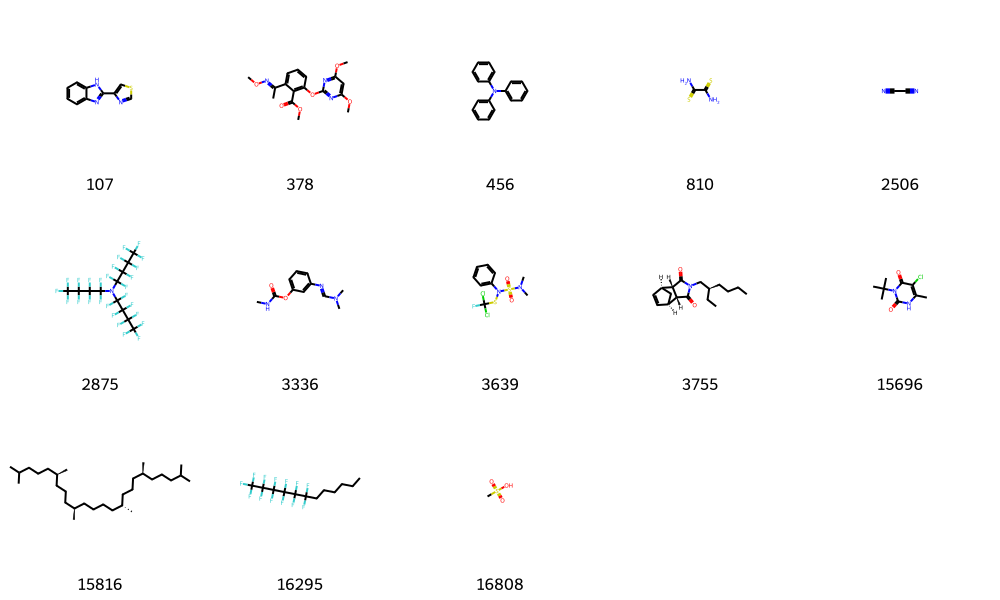

In [41]:
#get molregnos where physchem error is more then 1 log unit higher then mdfp error
molregnos_worst_physchem = df_results_avg[df_results_avg['error_PhysChem'] > df_results_avg['error_MDFP'] + 2].index.tolist()
print(len(molregnos_worst_physchem))
query = """
SELECT
    c.molregno,
    c.conf_id,
    c.molblock
FROM
    conformers c
JOIN
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
WHERE
    c.molregno IN %s;
"""
cur.execute(query, (tuple(molregnos_worst_physchem),))
data = cur.fetchall()
df_worst_physchem = pd.DataFrame(data, columns=['molregno', 'conf_id', 'molblock'])
df_worst_physchem = df_worst_physchem.sort_values('conf_id').drop_duplicates('molregno', keep='first')
mols = [Chem.MolFromMolBlock(molblock) for molblock in df_worst_physchem['molblock']]
mols = [m for m in mols if m is not None]
mols_2D = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
img = Draw.MolsToGridImage(mols_2D, molsPerRow=5, subImgSize=(200, 200), legends=[str(molregno) for molregno in df_worst_physchem['molregno']])
img
    

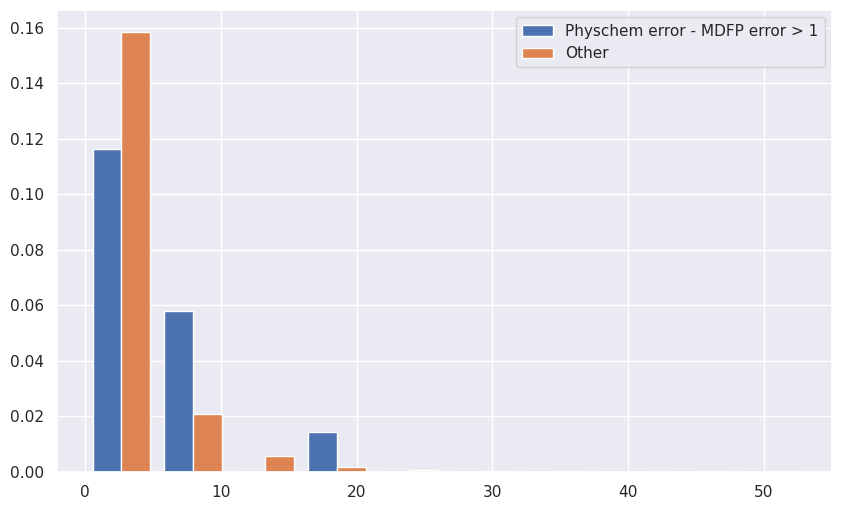

In [42]:
df_not_sampled = df_not_sampled.drop(columns=['NumRotatableBonds'])
df_not_sampled['NumRotatableBonds'] = df_not_sampled['ROMol'].apply(Descriptors.NumRotatableBonds)
df_features_physchem_worse = df_not_sampled[df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
df_features_physchem_better = df_not_sampled[~df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
num_rotatable_bonds_physchem_worse = df_features_physchem_worse['NumRotatableBonds'].values 
num_rotatable_bonds_physchem_better = df_features_physchem_better['NumRotatableBonds'].values
#binned histogram hist([worse, better], bins=10)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 6))
plt.hist([num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better], bins=10, label=['Physchem error - MDFP error > 1', 'Other'],density=True)
plt.legend(loc='upper right')

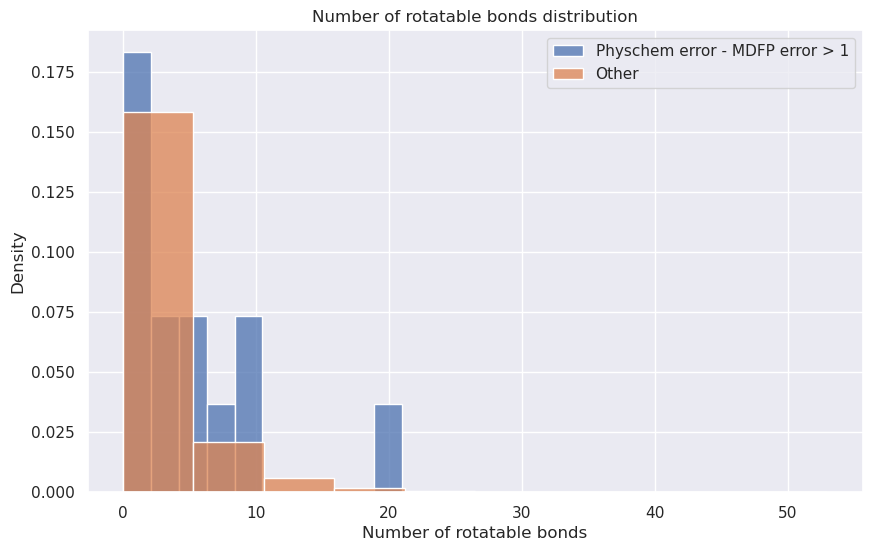

In [43]:
#also same but not binned, together with histplot
plt.figure(figsize=(10, 6))
sns.histplot(num_rotatable_bonds_physchem_worse, kde=False, label='Physchem error - MDFP error > 1',stat = 'density',bins=10)
sns.histplot(num_rotatable_bonds_physchem_better, kde=False, label='Other', stat='density',bins=10)
plt.legend(loc='upper right')
plt.title('Number of rotatable bonds distribution')
plt.xlabel('Number of rotatable bonds')
plt.ylabel('Density')
plt.show()

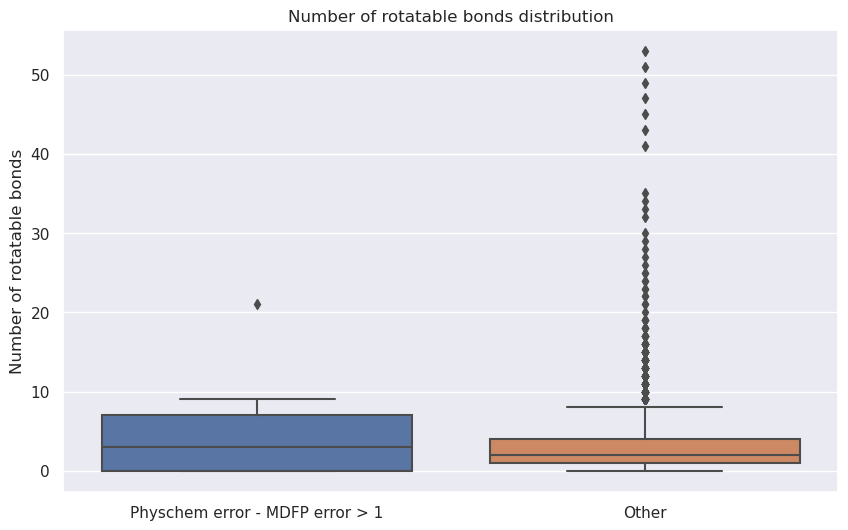

median rotatable bonds physchem error - mdfp error > 1: 3.0
median rotatable bonds other: 2.0


In [44]:
#boxplots of these num_rotatable_bonds_physchem_worse and num_rotatable_bonds_physchem_better
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10, 6))
sns.boxplot(data=[num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better])
plt.title('Number of rotatable bonds distribution')
plt.ylabel('Number of rotatable bonds')
plt.xticks([0,1], ['Physchem error - MDFP error > 1', 'Other'])
plt.show()
#print median of both
print('median rotatable bonds physchem error - mdfp error > 1:', np.median(num_rotatable_bonds_physchem_worse))
print('median rotatable bonds other:', np.median(num_rotatable_bonds_physchem_better))

In [45]:
from scipy.stats import ks_2samp
ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='two-sided', mode='auto')

KstestResult(statistic=0.2540119726820494, pvalue=0.3179498164172766, statistic_location=4, statistic_sign=-1)

78
KstestResult(statistic=0.05851758022416705, pvalue=0.9436134813109407, statistic_location=5, statistic_sign=-1)


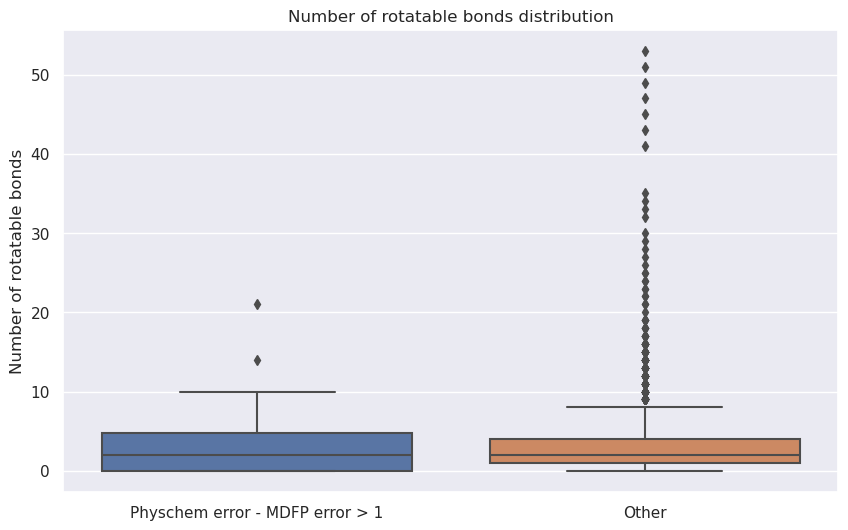

median rotatable bonds physchem error - mdfp error > 1: 2.0
median rotatable bonds other: 2.0


In [46]:
#repeat for mdfp error > 1
molregnos_worst_physchem = df_results_avg[df_results_avg['error_PhysChem'] > df_results_avg['error_MDFP'] + 1].index.tolist()
print(len(molregnos_worst_physchem))
df_features_physchem_worse = df_not_sampled[df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
df_features_physchem_better = df_not_sampled[~df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
num_rotatable_bonds_physchem_worse = df_features_physchem_worse['NumRotatableBonds'].values 
num_rotatable_bonds_physchem_better = df_features_physchem_better['NumRotatableBonds'].values
print(ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='two-sided', mode='auto'))
#boxplots of these num_rotatable_bonds_physchem_worse and num_rotatable_bonds_physchem_better
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10, 6))
sns.boxplot(data=[num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better])
plt.title('Number of rotatable bonds distribution')
plt.ylabel('Number of rotatable bonds')
plt.xticks([0,1], ['Physchem error - MDFP error > 1', 'Other'])
plt.show()
#print median of both
print('median rotatable bonds physchem error - mdfp error > 1:', np.median(num_rotatable_bonds_physchem_worse))
print('median rotatable bonds other:', np.median(num_rotatable_bonds_physchem_better))

247
KstestResult(statistic=0.12069888603311653, pvalue=0.0013096441409769731, statistic_location=1, statistic_sign=-1)


/tmp/ipykernel_2252337/2871364815.py:8: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  print(ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='less', mode='auto'))


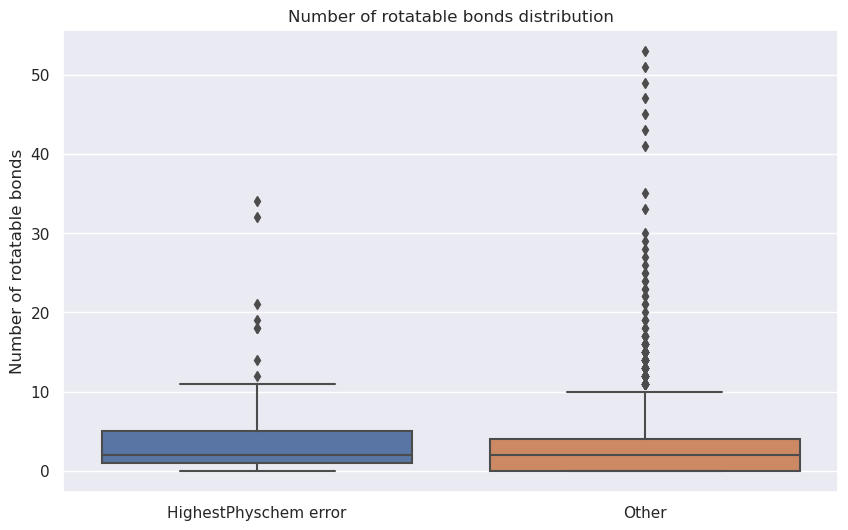

median rotatable bonds physchem error - mdfp error > 1: 2.0
median rotatable bonds other: 2.0


In [47]:
#and for just errors in error_PhysChem, say the highest 10%
molregnos_worst_physchem = df_results_avg[df_results_avg['error_PhysChem'] > df_results_avg['error_PhysChem'].quantile(0.90)].index.tolist()
print(len(molregnos_worst_physchem))
df_features_physchem_worse = df_not_sampled[df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
df_features_physchem_better = df_not_sampled[~df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
num_rotatable_bonds_physchem_worse = df_features_physchem_worse['NumRotatableBonds'].values 
num_rotatable_bonds_physchem_better = df_features_physchem_better['NumRotatableBonds'].values
print(ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='less', mode='auto'))
#boxplots of these num_rotatable_bonds_physchem_worse and num_rotatable_bonds_physchem_better
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10, 6))
sns.boxplot(data=[num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better])
plt.title('Number of rotatable bonds distribution')
plt.ylabel('Number of rotatable bonds')
plt.xticks([0,1], ['HighestPhyschem error', 'Other'])
plt.show()
#print median of both
print('median rotatable bonds physchem error - mdfp error > 1:', np.median(num_rotatable_bonds_physchem_worse))
print('median rotatable bonds other:', np.median(num_rotatable_bonds_physchem_better))

In [48]:
#another analysis, for molecules for which I can not use MDFP (error >2 ), can I use physchem? and other way around
#first, get the molregnos for which I can not use MDFP
molregnos_no_mdfp = df_results_avg[df_results_avg['error_MDFP'] > 2].index.tolist()
df_mdfp_bad = df_results_avg[df_results_avg.index.isin(molregnos_no_mdfp)]
#check how many of these I can use physchem
molregnos_no_mdfp_physchem = df_mdfp_bad[df_mdfp_bad['error_PhysChem'] < 2].index.tolist()
print(f'For {len(molregnos_no_mdfp_physchem)} out of  {len(molregnos_no_mdfp)} ({len(molregnos_no_mdfp_physchem)/len(molregnos_no_mdfp)*100:.2f}) mols where MDFP has an error over 2 log units, I coud use physchem')
#and the other way around
molregnos_no_physchem = df_results_avg[df_results_avg['error_PhysChem'] > 2].index.tolist()
df_physchem_bad = df_results_avg[df_results_avg.index.isin(molregnos_no_physchem)]
#check how many of these I can use mdfp
molregnos_no_physchem_mdfp = df_physchem_bad[df_physchem_bad['error_MDFP'] < 2].index.tolist()
print(f'For {len(molregnos_no_physchem_mdfp)} out of  {len(molregnos_no_physchem)} ({len(molregnos_no_physchem_mdfp)/len(molregnos_no_physchem)*100:.2f}) mols where physchem has an error over 2 log units, I coud use MDFP')

For 78 out of  122 (63.93) mols where MDFP has an error over 2 log units, I coud use physchem
For 43 out of  87 (49.43) mols where physchem has an error over 2 log units, I coud use MDFP


In [49]:
df_results_avg

,Pred_Physchem,vp_log10_pa,Pred_MDFP,Pred_MDFP_Physchem,error_PhysChem,error_MDFP,error_MDFP_PhysChem,best_method
molregno,,,,,,,,
8,-2.265454,-3.053298,-3.106580,-1.970587,0.787844,0.053282,1.082712,MDFP
11,5.291294,5.259101,5.247099,5.423377,0.032192,0.012002,0.164275,MDFP
12,-1.702674,-3.104198,-2.426734,-1.965896,1.401524,0.677464,1.138303,MDFP_PhysChem
15,4.232586,4.166000,3.905721,4.142222,0.066586,0.260279,0.023778,MDFP_PhysChem
18,2.762300,3.252703,2.874760,3.294998,0.490403,0.377943,0.042295,MDFP_PhysChem
...,...,...,...,...,...,...,...,...
17152,1.539953,1.683802,0.598803,1.427457,0.143849,1.085000,0.256346,PhysChem
17162,4.500741,4.463402,4.154649,4.585134,0.037338,0.308753,0.121732,PhysChem
17168,0.463909,0.769302,0.893736,0.527001,0.305393,0.124434,0.242301,MDFP_PhysChem


247
KstestResult(statistic=0.14293940388942175, pvalue=9.229307252597574e-05, statistic_location=1, statistic_sign=-1)


/tmp/ipykernel_2252337/151696235.py:8: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  print(ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='less', mode='auto'))


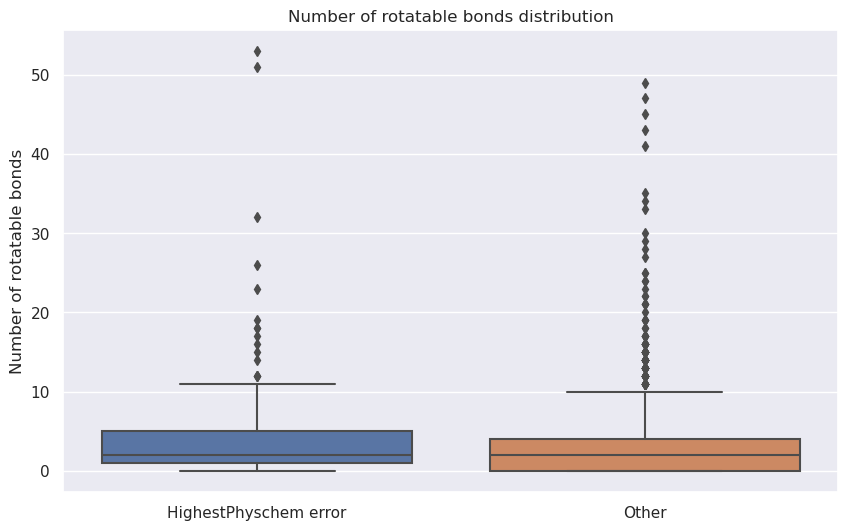

median rotatable bonds physchem error - mdfp error > 1: 2.0
median rotatable bonds other: 2.0


In [50]:
#and for just errors in error_PhysChem, say the highest 10%
molregnos_worst_physchem = df_results_avg[df_results_avg['error_MDFP'] > df_results_avg['error_MDFP'].quantile(0.90)].index.tolist()
print(len(molregnos_worst_physchem))
df_features_physchem_worse = df_not_sampled[df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
df_features_physchem_better = df_not_sampled[~df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
num_rotatable_bonds_physchem_worse = df_features_physchem_worse['NumRotatableBonds'].values 
num_rotatable_bonds_physchem_better = df_features_physchem_better['NumRotatableBonds'].values
print(ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='less', mode='auto'))
#boxplots of these num_rotatable_bonds_physchem_worse and num_rotatable_bonds_physchem_better
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10, 6))
sns.boxplot(data=[num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better])
plt.title('Number of rotatable bonds distribution')
plt.ylabel('Number of rotatable bonds')
plt.xticks([0,1], ['HighestPhyschem error', 'Other'])
plt.show()
#print median of both
print('median rotatable bonds physchem error - mdfp error > 1:', np.median(num_rotatable_bonds_physchem_worse))
print('median rotatable bonds other:', np.median(num_rotatable_bonds_physchem_better))

2218


/tmp/ipykernel_2252337/56405477.py:8: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  print(ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='less', mode='auto'))


KstestResult(statistic=0.14517074923557768, pvalue=1.2457688478582219e-08, statistic_location=0, statistic_sign=-1)


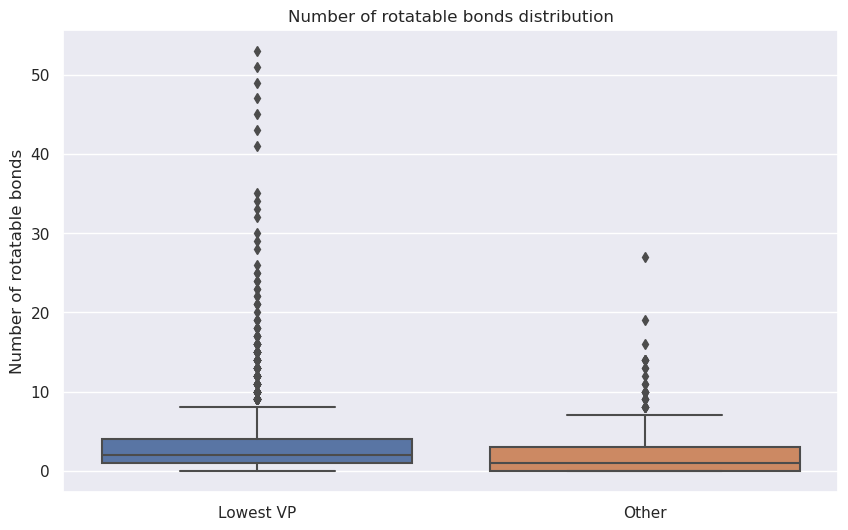

median rotatable bonds physchem error - mdfp error > 1: 2.0
median rotatable bonds other: 1.0


In [51]:
#and for just errors in error_PhysChem, say the highest 10%
molregnos_worst_physchem = df_results_avg[df_results_avg['vp_log10_pa'] < df_results_avg['vp_log10_pa'].quantile(0.90)].index.tolist()
print(len(molregnos_worst_physchem))
df_features_physchem_worse = df_not_sampled[df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
df_features_physchem_better = df_not_sampled[~df_not_sampled['molregno'].isin(molregnos_worst_physchem)]
num_rotatable_bonds_physchem_worse = df_features_physchem_worse['NumRotatableBonds'].values 
num_rotatable_bonds_physchem_better = df_features_physchem_better['NumRotatableBonds'].values
print(ks_2samp(num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better,alternative='less', mode='auto'))
#boxplots of these num_rotatable_bonds_physchem_worse and num_rotatable_bonds_physchem_better
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10, 6))
sns.boxplot(data=[num_rotatable_bonds_physchem_worse, num_rotatable_bonds_physchem_better])
plt.title('Number of rotatable bonds distribution')
plt.ylabel('Number of rotatable bonds')
plt.xticks([0,1], ['Lowest VP', 'Other'])
plt.show()
#print median of both
print('median rotatable bonds physchem error - mdfp error > 1:', np.median(num_rotatable_bonds_physchem_worse))
print('median rotatable bonds other:', np.median(num_rotatable_bonds_physchem_better))

In [52]:
rng = np.random.default_rng()
sample1 = stats.norm.rvs(size=105, loc=0.5, random_state=rng)
sample2 = stats.norm.rvs(size=95, random_state=rng)
print(np.median(sample1), np.median(sample2))
print(stats.ks_2samp(sample1, sample2, alternative='less'))
print(stats.ks_2samp(sample1, sample2, alternative='greater'))

0.4265818722852861 -0.06921928198651113
KstestResult(statistic=0.2781954887218045, pvalue=0.0003276144490023885, statistic_location=-0.4467310401958727, statistic_sign=-1)
KstestResult(statistic=0.01904761904761905, pvalue=0.9496487598170417, statistic_location=-2.1461612611944716, statistic_sign=1)


In [53]:
df_results
#add num_rotatable_bonds to df_results, matched from df_not_sampled by molregno
df_results['NumRotatableBonds'] = df_results['molregno'].map(df_not_sampled.set_index('molregno')['NumRotatableBonds'])
print(df_results['NumRotatableBonds'].value_counts())
##split these over 3 equally sized population bins
df_results['NumRotatableBonds_bin'] = pd.qcut(df_results['NumRotatableBonds'], 3, labels=['low', 'medium', 'high'])
df_results['NumRotatableBonds_bin'].value_counts()
#see if the error is significantly different between these bins, using friedman test, followed by posthoc
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
df_results['error_PhysChem'] = abs(df_results['error_PhysChem'])

low = df_results[df_results['NumRotatableBonds_bin'] == 'low']['error_PhysChem'].values
medium = df_results[df_results['NumRotatableBonds_bin'] == 'medium']['error_PhysChem'].values
high = df_results[df_results['NumRotatableBonds_bin'] == 'high']['error_PhysChem'].values

#plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10, 6))
sns.boxplot(data=[low, medium, high])
plt.title('Error PhysChem distribution')
plt.ylabel('Error PhysChem')
plt.xticks([0,1,2], ['low', 'medium', 'high'])
plt.show()

NumRotatableBonds
0     1338
1     1253
2      847
3      473
4      436
5      250
6      206
7      140
8      122
9       89
10      52
15      44
12      40
11      33
14      29
13      26
16      23
17      15
18      10
19      10
21       7
53       6
22       6
49       5
45       5
33       4
25       4
23       4
41       4
47       3
28       2
24       2
51       2
29       2
26       2
20       1
32       1
35       1
43       1
34       1
30       1
Name: count, dtype: int64


ModuleNotFoundError: No module named 'scikit_posthocs'

In [ ]:
df_features_physchem_worse['NumRotatableBonds'].values.tolist()

[7,
 2,
 18,
 3,
 3,
 3,
 5,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 6,
 4,
 2,
 5,
 4,
 3,
 9,
 5,
 2,
 3,
 4,
 1,
 6,
 5,
 0,
 8,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 9,
 2,
 7,
 9,
 7,
 3,
 4,
 5,
 7,
 3,
 6,
 0,
 0,
 8,
 0,
 2,
 0,
 1,
 0]

In [ ]:
df_not_sampled

,molregno,conf_id,vp_log10_pa,mdfp,molblock,mdfp_vec,NumHeavyAtoms,NumN,NumO,NumF,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,population_bin,NumRotatableBonds
3240,8,1151,-3.053298,"{'mdfp': '[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97....",[H]OC(=O)c1c([H])c([H])c2c([H])c([H])c([H])c([...,"[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...",13.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,2,1
17,9,1152,3.593202,"{'mdfp': '[5, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0.484...",[H]C([H])(Cl)OC([H])([H])Cl\n RDKit ...,"[5, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0.4848459757350...",5.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,9,2
9903,11,1154,5.259101,"{'mdfp': '[4, 0, 0, 0, 1, 0, 0, 2, 0, 0, -0.10...",[H]C(F)(Cl)Cl\n RDKit 3D\n\n 0 ...,"[4, 0, 0, 0, 1, 0, 0, 2, 0, 0, -0.104781552046...",4.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,10,0
9905,12,1155,-3.104198,"{'mdfp': '[13, 3, 0, 3, 0, 0, 0, 1, 0, 0, -105...",[H]OC(=O)C([H])([H])Oc1c([H])c([H])c(Cl)c([H])...,"[13, 3, 0, 3, 0, 0, 0, 1, 0, 0, -105.003804343...",13.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,2,3
19,13,1156,3.664201,"{'mdfp': '[6, 2, 0, 0, 0, 0, 0, 0, 1, 0, -1.41...",[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H]...,"[6, 2, 0, 0, 0, 0, 0, 0, 1, 0, -1.410024750661...",6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551,3749,17247,1.036000,"{'mdfp': '[11, 1, 0, 1, 0, 0, 0, 0, 0, 0, -22....",[H]C([H])=C(C([H])([H])[H])[C@]1([H])C([H])([H...,"[11, 1, 0, 1, 0, 0, 0, 0, 0, 0, -22.7079118557...",11.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,5,1
9891,2545,17253,2.301000,"{'mdfp': '[4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5.357...",[H]/C(I)=C(\[H])I\n RDKit 3D\n\n ...,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5.3572325631171...",4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7,0
13099,3394,17254,2.296000,"{'mdfp': '[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.0...",[H]O[C@]1([H])C([H])([H])C([H])([H])C([H])([H]...,"[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.02947008199...",8.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,7,0
9894,2680,17260,2.216000,"{'mdfp': '[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.1...",[H]O[C@]1([H])C([H])([H])C([H])([H])C([H])([H]...,"[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.16582824638...",8.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,7,0


funny: some are extremely flexible, others are completely rigid

In [54]:
#add the gnn comparison: load data
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_AttentiveFP_DASH_charges.pkl', 'rb') as f:
    data_DASH_charge = pickle.load(f)
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_AttentiveFP_Gasteiger.pkl', 'rb') as f:
    data_attentivefp_Gasteiger = pickle.load(f)
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_AttentiveFP_no_charge.pkl', 'rb') as f:
    data_attentivefp_no_charge = pickle.load(f)

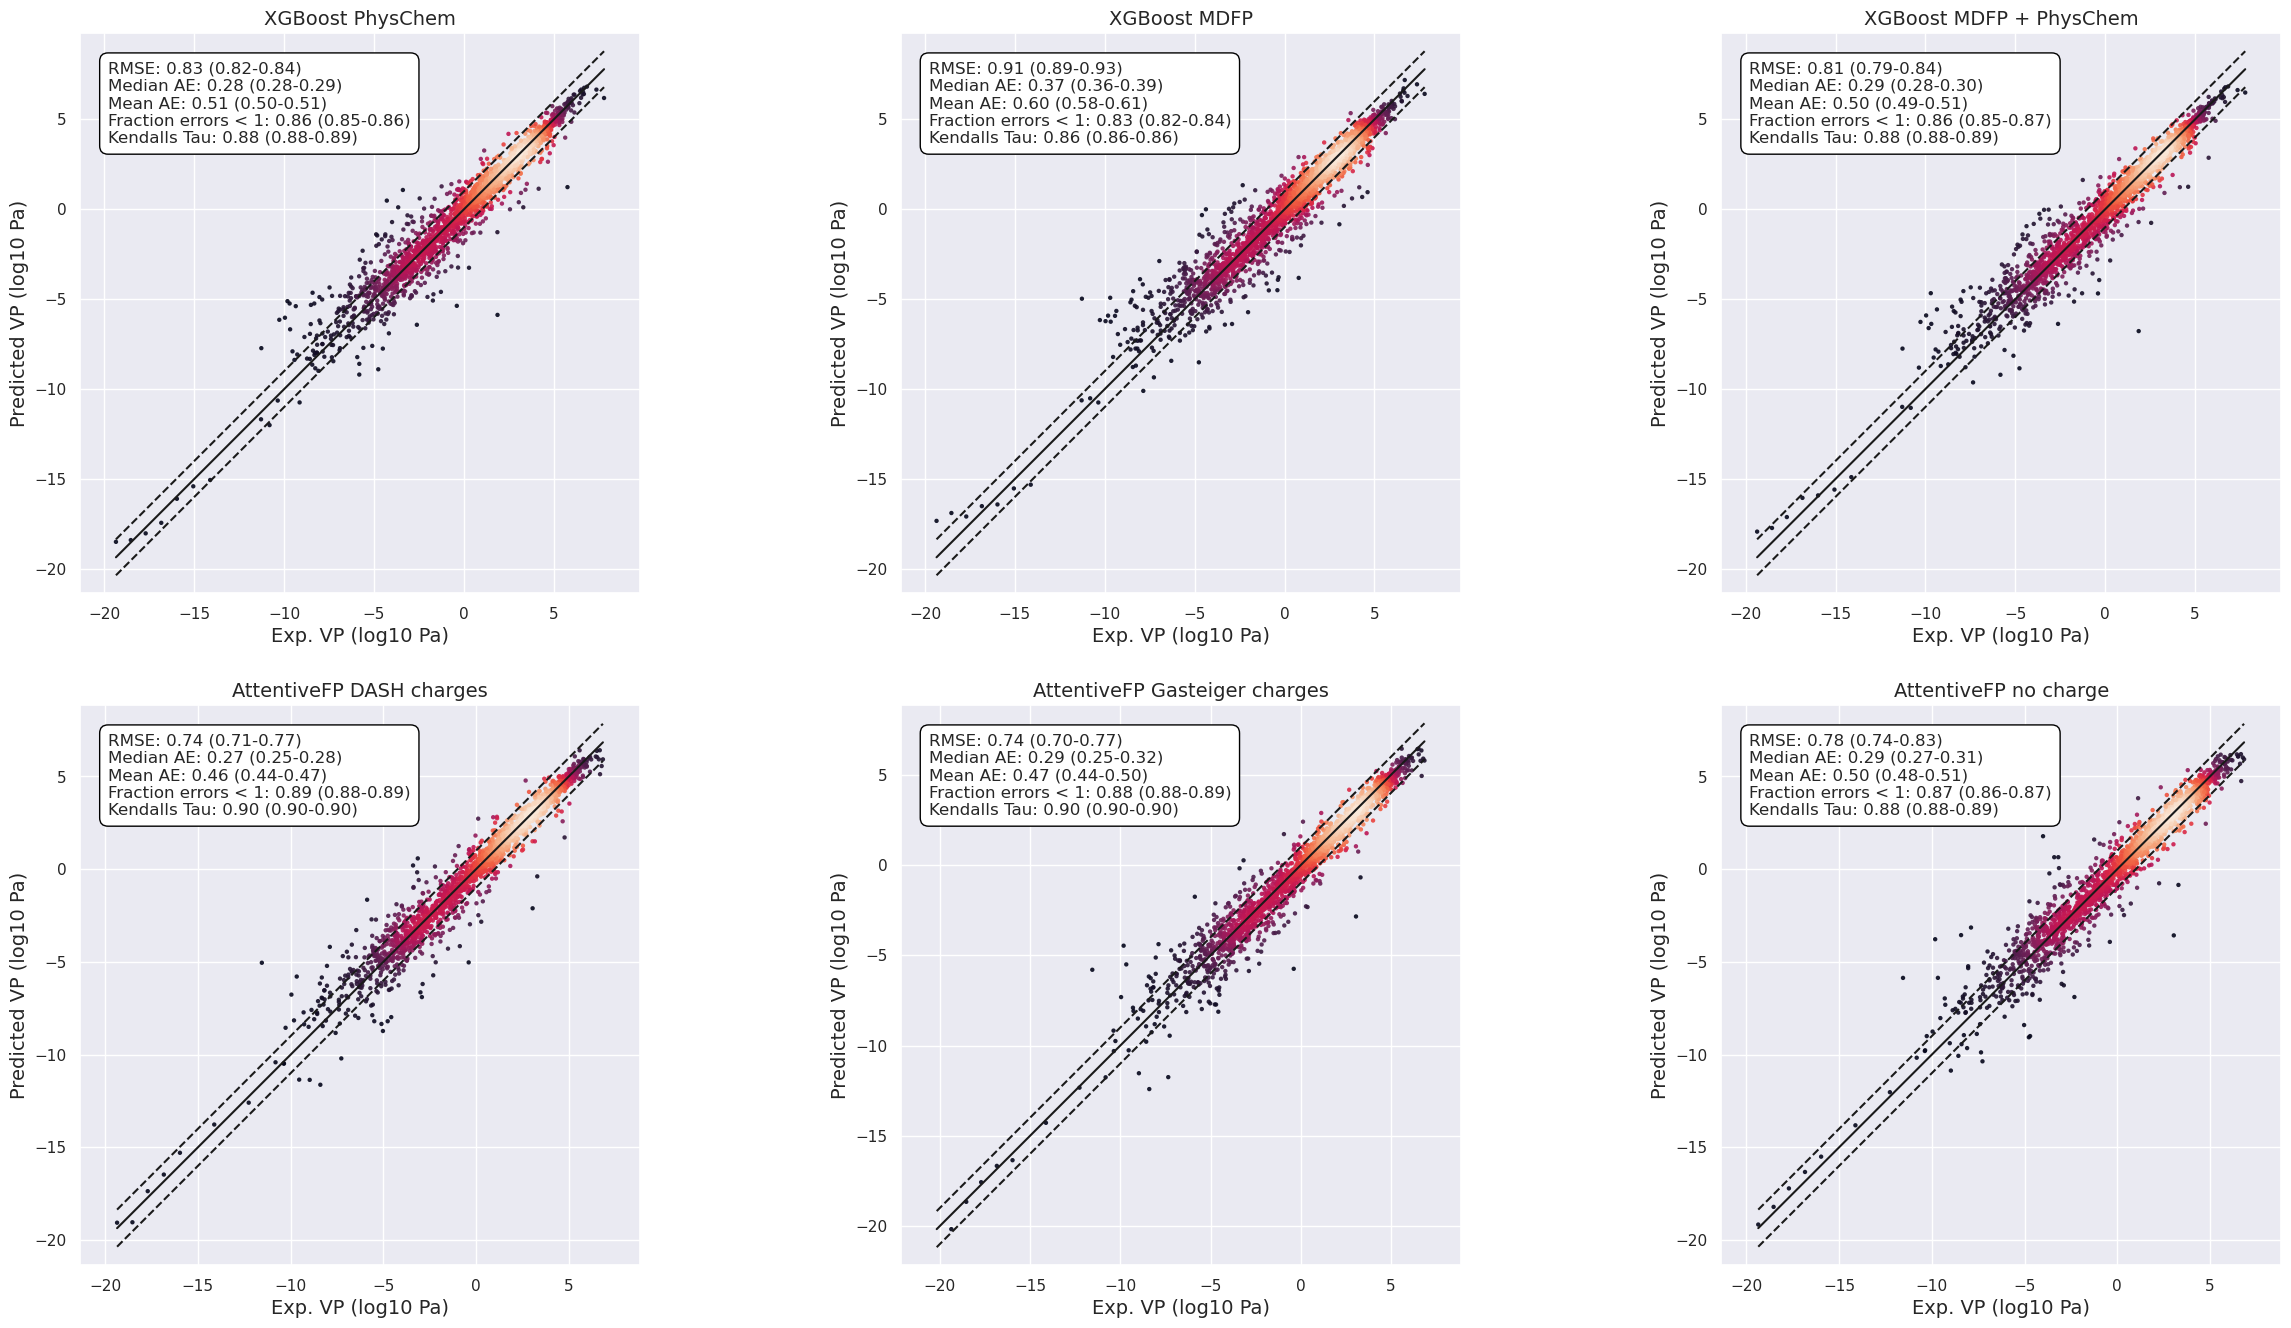

In [55]:
#now plot all 6 methods in one plot
reals_list = [ys_list_xgboost_physchem, ys_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_and_physchem, data_DASH_charge['ys'], data_attentivefp_Gasteiger['ys'], data_attentivefp_no_charge['ys']]
predictions_list = [pred_list_xgboost_physchem, pred_list_xgboost_mdfp_plus, pred_list_xgboost_mdfp_and_physchem, data_DASH_charge['preds'], data_attentivefp_Gasteiger['preds'], data_attentivefp_no_charge['preds']]
molregnos_list = [molregnos_xgboost_physchem, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus, data_DASH_charge['molregnos'], data_attentivefp_Gasteiger['molregnos'], data_attentivefp_no_charge['molregnos']]
title = ['XGBoost PhysChem', 'XGBoost MDFP', 'XGBoost MDFP + PhysChem', 'AttentiveFP DASH charges', 'AttentiveFP Gasteiger charges', 'AttentiveFP no charge']
density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, title=title, name='All_methods', dims=(2,3))


In [56]:
#is any of these statistically significantly better then the others?
from scipy.stats import friedmanchisquare, wilcoxon
from scikit_posthocs import posthoc_nemenyi_friedman

POSITVE_METRICS = ['kendall', 'Fraction < 1.0']
NEGATIVE_METRICS = ['RMSE', 'MAE', 'Median AE']

def get_stat_df(input_df,variable, metric):
    metric_lists = []
    for v in input_df[variable].unique():
        metric_lists.append(input_df[input_df[variable] == v][metric].tolist())
    df_metric= pd.DataFrame(metric_lists, index=input_df[variable].unique())
    return df_metric.T

def stat_test(groups,group_names,metric,alpha=0.05):
    #if more then two groups:
    if len(groups) > 2:
        try:
            assert np.all([len(g) >= 6 for g in groups])
        except AssertionError:
            print('Friedman test requires at least 6 samples per group')
            #print how many samples per group
            for i, g in enumerate(groups):
                print(f'{group_names[i]}: {len(g)}')
            return
        stat, p = friedmanchisquare(*groups)
        print('Friedman Statistics=%.3f, p=%.3f' % (stat, p))
        if p > alpha:
            print('Same distributions (fail to reject H0)')
        else:
            print('Different distributions (reject H0)')
            data = np.array(groups).T
            if metric in POSITVE_METRICS:
                dat_best = posthoc_nemenyi_friedman(data)[np.argmax(np.median(data, axis=0))]
            elif metric in NEGATIVE_METRICS:
                dat_best = posthoc_nemenyi_friedman(data)[np.argmin(np.median(data, axis=0))]
            else:
                print('Metric not recognized')
                return
            dat_best = dat_best[dat_best.index != dat_best.name]
            if np.all(dat_best < alpha):
                print(f'Best group {group_names[int(dat_best.name)]} is significantly different from all other groups')
            else:
                print('Best group is not significantly different from all other groups')
                #print out for which ones it is significantly different
                for i, v in enumerate(dat_best):
                    if v < alpha:
                        print(f'{group_names[int(dat_best.index[i])]} is significantly different from {group_names[int(dat_best.name)]}')
      
    else:
        stat, p = wilcoxon(x = groups[0], y = groups[1])
        print('Wilcoxon Statistics=%.3f, p=%.3f' % (stat, p))
        if p > alpha:
            print('Same distributions (fail to reject H0)')
        else:
            print('Different distributions (reject H0)')
            #print names and medians
            for i, v in enumerate(groups):
                print(f'{group_names[i]}: {np.round(np.median(v),3)}')
        


ModuleNotFoundError: No module named 'scikit_posthocs'

In [ ]:
#make df with relevant metrics (RMSE	MAE	kendall	Fraction < 0.3	Fraction < 1.0), for each method and split. so expect 10 split x 6 methods = 60 rows
#first get the metrics for each method
def calculate_stats(ys_list, pred_list):
    rmses, maes, kts, ebo, median_aes = [], [], [], [], []
    for i in range(10):
        rmses.append(mean_squared_error(ys_list[i], pred_list[i], squared=False))
        maes.append(mean_absolute_error(ys_list[i], pred_list[i]))
        kts.append(stats.kendalltau(ys_list[i], pred_list[i])[0])
        ebo.append(np.mean(np.abs(np.array(ys_list[i]) - np.array(pred_list[i])) < 1.0))
        median_aes.append(median_absolute_error(ys_list[i], pred_list[i]))
    return pd.DataFrame({'RMSE': rmses, 'MAE': maes, 'kendall': kts, 'Fraction < 1.0': ebo, 'Median AE': median_aes})

# Calculate stats for each method
df_physchem = calculate_stats(ys_list_xgboost_physchem, pred_list_xgboost_physchem)
df_mdfp = calculate_stats(ys_list_xgboost_mdfp_plus, pred_list_xgboost_mdfp_plus)
df_mdfp_physchem = calculate_stats(ys_list_xgboost_mdfp_and_physchem, pred_list_xgboost_mdfp_and_physchem)
df_DASH_charge = calculate_stats(data_DASH_charge['ys'], data_DASH_charge['preds'])
df_attentivefp_Gasteiger = calculate_stats(data_attentivefp_Gasteiger['ys'], data_attentivefp_Gasteiger['preds'])
df_attentivefp_no_charge = calculate_stats(data_attentivefp_no_charge['ys'], data_attentivefp_no_charge['preds'])

# Combine into one dataframe
df_all = pd.concat([df_physchem, df_mdfp, df_mdfp_physchem, df_DASH_charge, df_attentivefp_Gasteiger, df_attentivefp_no_charge], axis=0)
df_all['source'] = ['XGBoost PhysChem']*10 + ['XGBoost MDFP']*10 + ['XGBoost MDFP + PhysChem']*10 + ['DASH charges']*10 + ['AttentiveFP Gasteiger']*10 + ['AttentiveFP no charge']*10
df_all['split'] = list(range(10))*6
df_all['RMSE'] = df_all['RMSE'].astype(float)
df_all['MAE'] = df_all['MAE'].astype(float)
df_all['kendall'] = df_all['kendall'].astype(float)
df_all['Fraction < 1.0'] = df_all['Fraction < 1.0'].astype(float)
df_all['Median AE'] = df_all['Median AE'].astype(float)

#same for only XGBOOST ones and attentivefp ones
df_all_xgboost = pd.concat([df_physchem, df_mdfp, df_mdfp_physchem], axis=0)
df_all_xgboost['source'] = ['XGBoost PhysChem']*10 + ['XGBoost MDFP']*10 + ['XGBoost MDFP + PhysChem']*10
df_all_xgboost['split'] = list(range(10))*3
df_all_xgboost['RMSE'] = df_all_xgboost['RMSE'].astype(float)
df_all_xgboost['MAE'] = df_all_xgboost['MAE'].astype(float)
df_all_xgboost['kendall'] = df_all_xgboost['kendall'].astype(float)
df_all_xgboost['Fraction < 1.0'] = df_all_xgboost['Fraction < 1.0'].astype(float)
df_all_xgboost['Median AE'] = df_all_xgboost['Median AE'].astype(float)

df_all_attentivefp = pd.concat([df_DASH_charge, df_attentivefp_Gasteiger, df_attentivefp_no_charge], axis=0)
df_all_attentivefp['source'] = ['DASH charges']*10 + ['AttentiveFP Gasteiger']*10 + ['AttentiveFP no charge']*10
df_all_attentivefp['split'] = list(range(10))*3
df_all_attentivefp['RMSE'] = df_all_attentivefp['RMSE'].astype(float)
df_all_attentivefp['MAE'] = df_all_attentivefp['MAE'].astype(float)
df_all_attentivefp['kendall'] = df_all_attentivefp['kendall'].astype(float)
df_all_attentivefp['Fraction < 1.0'] = df_all_attentivefp['Fraction < 1.0'].astype(float)
df_all_attentivefp['Median AE'] = df_all_attentivefp['Median AE'].astype(float)

In [ ]:
for metric in df_all.columns[:5]:
    print(metric)
    df_metric = get_stat_df(df_all,'source', metric)
    stat_test(df_metric.values.T, df_metric.columns.tolist(),metric=metric)

RMSE
Friedman Statistics=29.029, p=0.000
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is significantly different from AttentiveFP Gasteiger
MAE
Friedman Statistics=28.286, p=0.000
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is significantly different from AttentiveFP Gasteiger
kendall
Friedman Statistics=40.400, p=0.000
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost PhysChem is significantly different from AttentiveFP Gasteiger
XGBoost MDFP is significantly different from AttentiveFP Gasteiger
XGBoost MDFP + PhysChem is significantly different from AttentiveFP Gasteiger
Fraction < 1.0
Friedman Statistics=32.114, p=0.000
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is significantly different from DASH charges
Median AE
Friedm

In [ ]:
for metric in df_all_xgboost.columns[:5]:
    print(metric)
    df_metric = get_stat_df(df_all_xgboost,'source', metric)
    stat_test(df_metric.values.T, df_metric.columns.tolist(),metric=metric)

RMSE
Friedman Statistics=16.800, p=0.000
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is significantly different from XGBoost MDFP + PhysChem
MAE
Friedman Statistics=15.200, p=0.001
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is significantly different from XGBoost PhysChem
kendall
Friedman Statistics=15.200, p=0.001
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is significantly different from XGBoost PhysChem
Fraction < 1.0
Friedman Statistics=15.800, p=0.000
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is significantly different from XGBoost PhysChem
Median AE
Friedman Statistics=15.000, p=0.001
Different distributions (reject H0)
Best group is not significantly different from all other groups
XGBoost MDFP is signifi

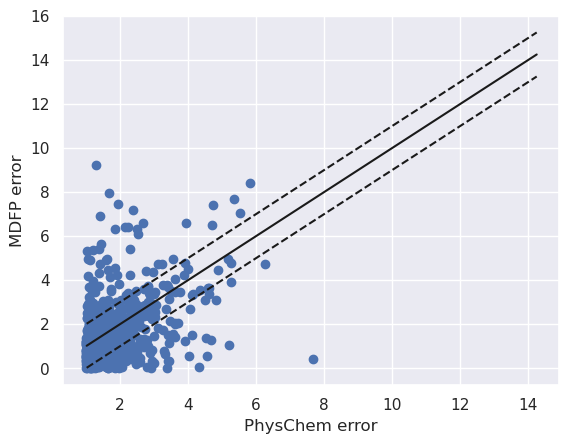

In [ ]:
#I guess another question to ask: for the molecules we can't model with xgboost physchem, are they better modeled with mdfp?
#first, get the molregnos that have an error of > 1 log unit for physchem
df_physchem_unreliable = df_results[df_results['error_PhysChem'] > 1]
df_physchem_unreliable
#scatter of errors against each other, with diagonal line, plus +- 1
fig, ax = plt.subplots()
ax.scatter(df_physchem_unreliable['error_PhysChem'], df_physchem_unreliable['error_MDFP'])
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], 'k-')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1], 'k--')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1], 'k--')
ax.set_xlabel('PhysChem error')
ax.set_ylabel('MDFP error')
plt.show()

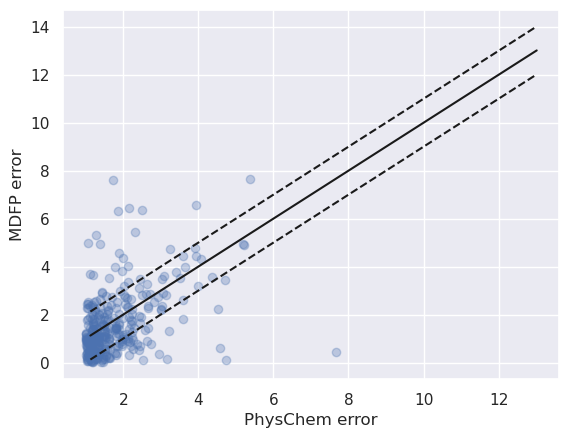

In [ ]:
df_physchem_unreliable = df_results_avg[df_results_avg['error_PhysChem'] > 1]
df_physchem_unreliable
#scatter of errors against each other, with diagonal line, plus +- 1
fig, ax = plt.subplots()
ax.scatter(df_physchem_unreliable['error_PhysChem'], df_physchem_unreliable['error_MDFP'],alpha=0.3)
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], 'k-')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1], 'k--')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1], 'k--')
ax.set_xlabel('PhysChem error')
ax.set_ylabel('MDFP error')
plt.show()

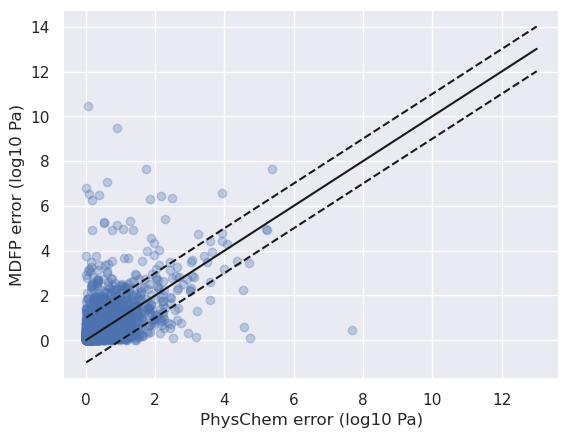

In [ ]:
df_physchem_unreliable = df_results_avg.copy()
df_physchem_unreliable
#scatter of errors against each other, with diagonal line, plus +- 1
fig, ax = plt.subplots()
ax.scatter(df_physchem_unreliable['error_PhysChem'], df_physchem_unreliable['error_MDFP'],alpha=0.3)
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], 'k-')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1], 'k--')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1], 'k--')
ax.set_xlabel('PhysChem error (log10 Pa)')
ax.set_ylabel('MDFP error (log10 Pa)')
plt.show()

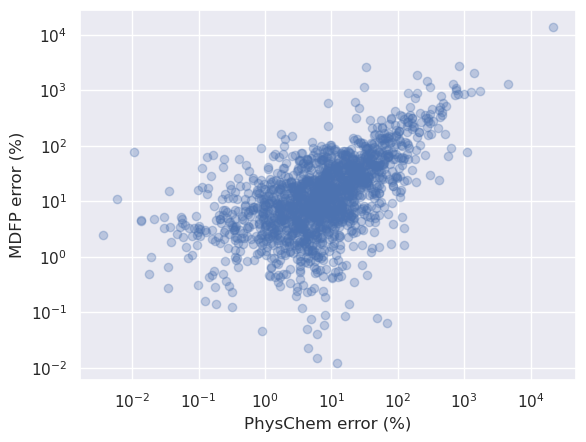

In [ ]:
#repeat, but with error expressed as percentage of the real value
df_physchem_unreliable = df_results_avg.copy()
df_physchem_unreliable['error_PhysChem'] = abs(df_physchem_unreliable['vp_log10_pa'] - df_physchem_unreliable['Pred_Physchem'])/df_physchem_unreliable['vp_log10_pa']*100
df_physchem_unreliable['error_MDFP'] = abs(df_physchem_unreliable['vp_log10_pa'] - df_physchem_unreliable['Pred_MDFP'])/df_physchem_unreliable['vp_log10_pa']*100
df_physchem_unreliable['error_MDFP_PhysChem'] = abs(df_physchem_unreliable['vp_log10_pa'] - df_physchem_unreliable['Pred_MDFP_Physchem'])/df_physchem_unreliable['vp_log10_pa']*100
#scatter of errors against each other, with diagonal line, plus +- 1
fig, ax = plt.subplots()
ax.scatter(df_physchem_unreliable['error_PhysChem'], df_physchem_unreliable['error_MDFP'],alpha=0.3)
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], 'k-')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) - 1], 'k--')
ax.plot([min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']), max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP'])], [min(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1, max(df_physchem_unreliable['error_PhysChem'] + df_physchem_unreliable['error_MDFP']) + 1], 'k--')
ax.set_xlabel('PhysChem error (%)')
ax.set_ylabel('MDFP error (%)')
#use log scale
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

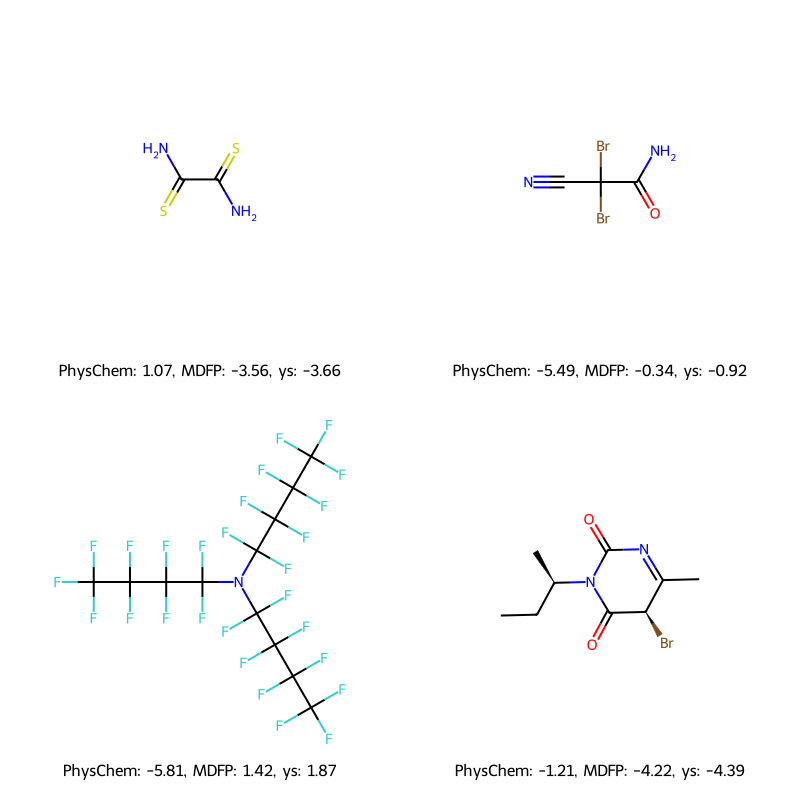

In [ ]:
#get df where error_PhysChem-error_MDFP > 3
df_physchem_unreliable = df_results_avg[df_results_avg['error_PhysChem'] > df_results_avg['error_MDFP'] + 3]
#for these, get the mols from the molregnos, and preds from both, draw them
molregnos = df_physchem_unreliable.index.tolist()
query = """
SELECT
    c.molregno,
    c.conf_id,
    c.molblock
FROM
    conformers c
JOIN
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
WHERE
    c.molregno IN %s;
"""
cur.execute(query, (tuple(molregnos),))
data = cur.fetchall()
df_physchem_unreliable = pd.DataFrame(data, columns=['molregno', 'conf_id', 'molblock'])
df_physchem_unreliable = df_physchem_unreliable.sort_values('conf_id').drop_duplicates('molregno', keep='first')
mols = [Chem.MolFromMolBlock(molblock) for molblock in df_physchem_unreliable['molblock']]
mols = [m for m in mols if m is not None]
mols_2D = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
#get preds
pred_physchem, pred_mdfp, ys = [], [], []
for molregno in molregnos:
    pred_physchem.append(df_results_avg.loc[molregno, 'Pred_Physchem'])
    pred_mdfp.append(df_results_avg.loc[molregno, 'Pred_MDFP'])
    ys.append(df_results_avg.loc[molregno, 'vp_log10_pa'])
#draw
img = Draw.MolsToGridImage(mols_2D, molsPerRow=2, subImgSize=(400, 400), legends=[f'PhysChem: {p:.2f}, MDFP: {m:.2f}, ys: {y:.2f}' for p, m, y in zip(pred_physchem, pred_mdfp, ys)])
img

In [ ]:
#count how many of these have an mdfp error of > 1 log unit
print('Number of molecules with physchem error > 1 log unit:', len(df_physchem_unreliable))
print('Number of molecules with mdfp error > 1 log unit:', len(df_physchem_unreliable[df_physchem_unreliable['error_MDFP'] > 1]))

Number of molecules with physchem error > 1 log unit: 323
Number of molecules with mdfp error > 1 log unit: 190


/tmp/ipykernel_342530/254079543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_physchem_unreliable['error_diff'] = df_physchem_unreliable['error_PhysChem'] - df_physchem_unreliable['error_MDFP']


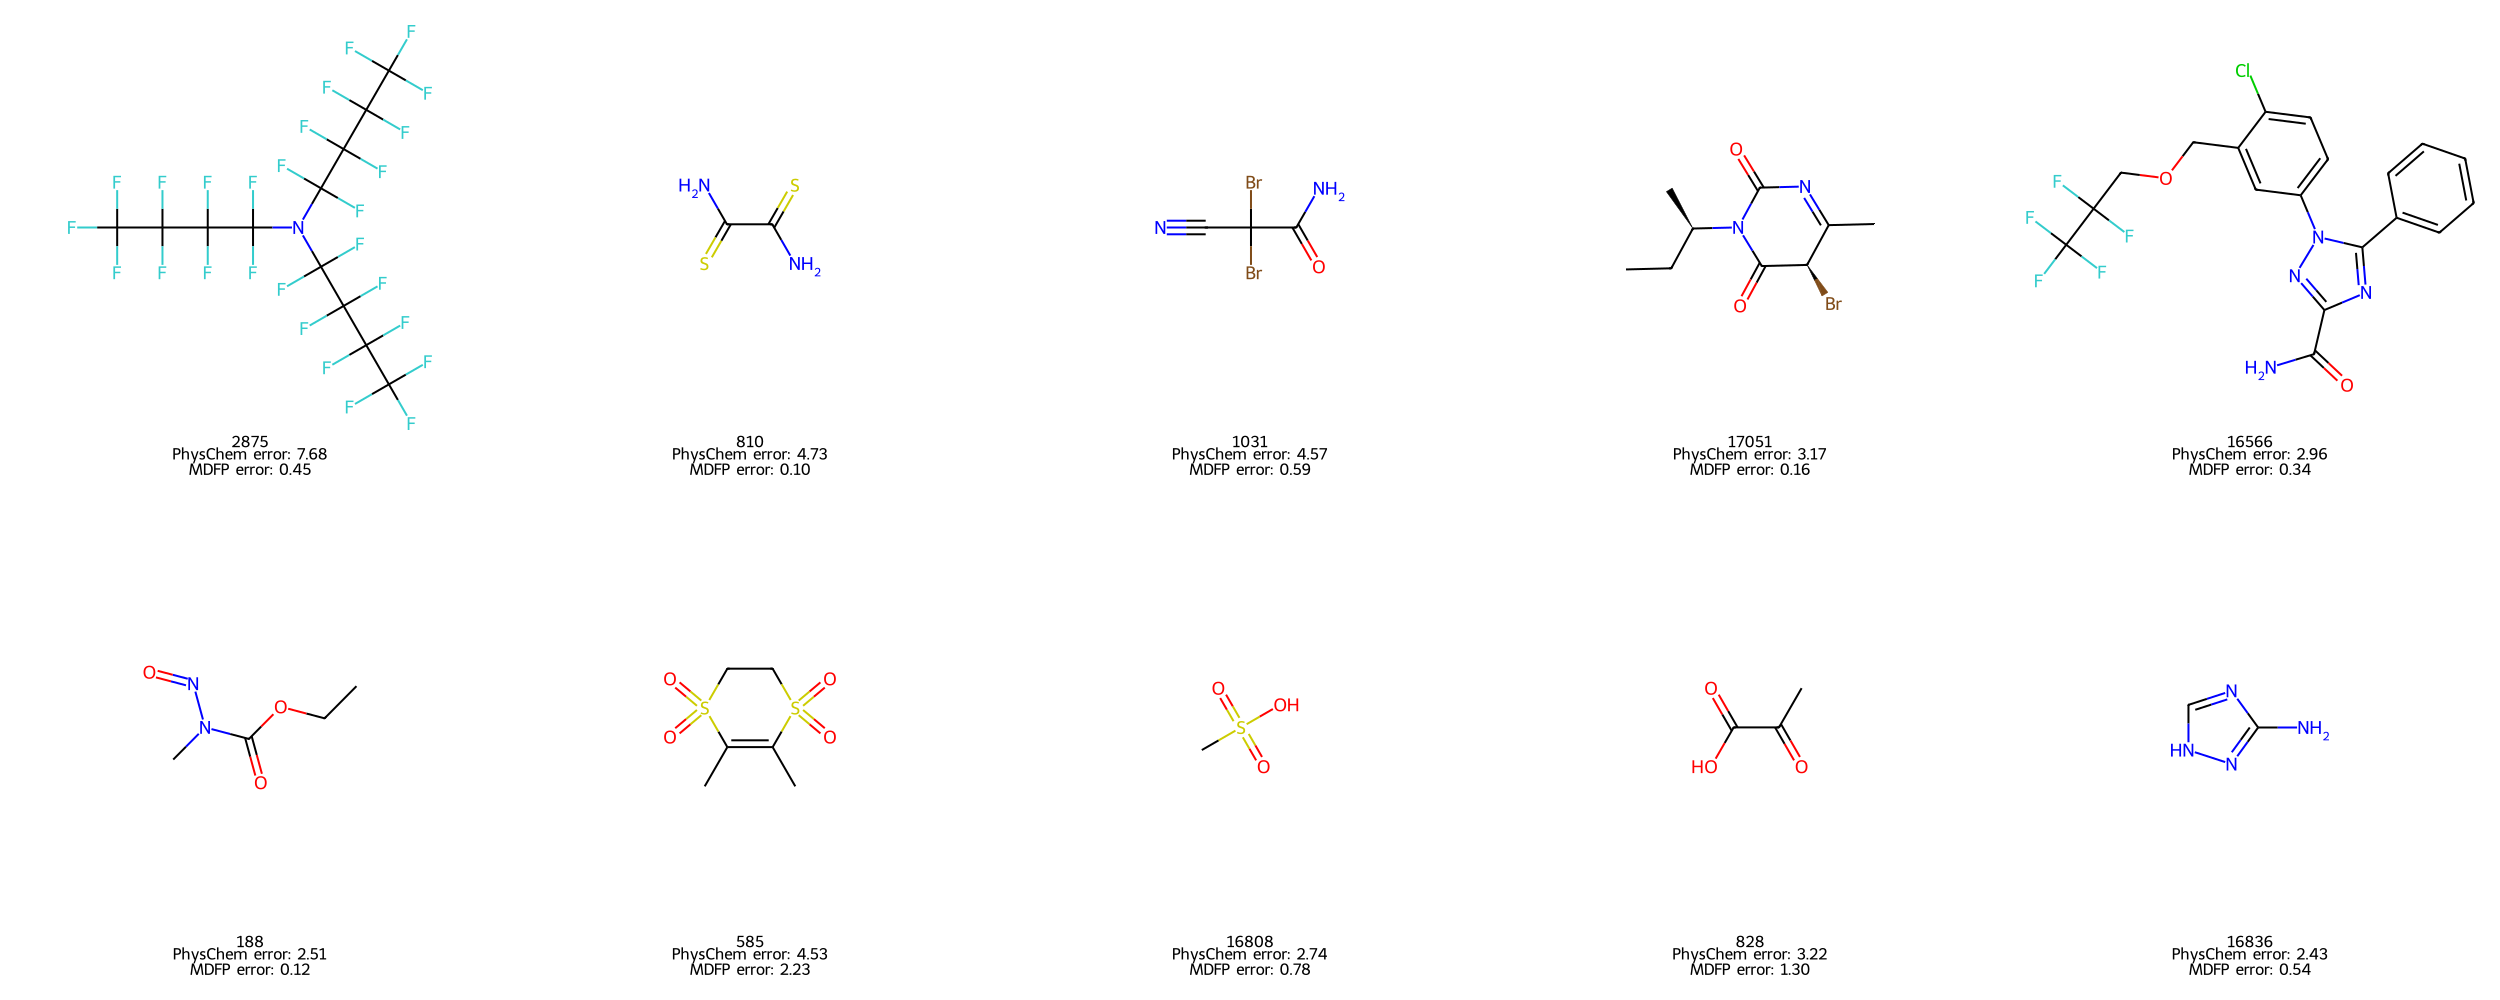

In [ ]:
#look at the 10 datapoints with the biggest difference between physchem and mdfp error
df_physchem_unreliable['error_diff'] = df_physchem_unreliable['error_PhysChem'] - df_physchem_unreliable['error_MDFP']
df_physchem_unreliable.sort_values('error_diff', ascending=False).head(10)
#get those molregnos and draw
molregnos_worst_diff = df_physchem_unreliable.sort_values('error_diff', ascending=False).head(10).index.tolist()
query = """
SELECT
    c.molregno,
    c.conf_id,
    c.molblock
FROM
    conformers c
JOIN
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
WHERE
    c.molregno IN %s;
"""
cur.execute(query, (tuple(molregnos_worst_diff),))
data = cur.fetchall()
df_worst_diff = pd.DataFrame(data, columns=['molregno', 'conf_id', 'molblock'])
df_worst_diff = df_worst_diff.sort_values('conf_id').drop_duplicates('molregno', keep='first')
mols = [Chem.MolFromMolBlock(molblock) for molblock in df_worst_diff['molblock']]
mols = [m for m in mols if m is not None]
mols_2D = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
#get error of both for legend
molregnos = df_worst_diff['molregno'].tolist()
error_physchem, error_mdfp = [], []
for mrno in molregnos:
    error_physchem.append(df_results_avg.loc[mrno, 'error_PhysChem'])
    error_mdfp.append(df_results_avg.loc[mrno, 'error_MDFP'])
#sort these by error difference: highest first
error_diffs = [error_physchem[i] - error_mdfp[i] for i in range(len(molregnos))]
#sort error_physchem, error_mdfp, molregnos, mols_2D by error_diffs
error_physchem = [x for _, x in sorted(zip(error_diffs, error_physchem), reverse=True)]
error_mdfp = [x for _, x in sorted(zip(error_diffs, error_mdfp), reverse=True)]
molregnos = [x for _, x in sorted(zip(error_diffs, molregnos), reverse=True)]
mols_2D = [x for _, x in sorted(zip(error_diffs, mols_2D), reverse=True)]


img = Draw.MolsToGridImage(mols_2D, molsPerRow=5, subImgSize=(500, 500), legends=[f'{mrno}\nPhysChem error: {error_physchem[i]:.2f}\nMDFP error: {error_mdfp[i]:.2f}' for i, mrno in enumerate(molregnos)])
img

In [ ]:
#can we do an experiment? add counts of F to features physchem and pred again
element_counts = ['NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI']
pred_list_xgboost_physchem_element_counts, ys_list_xgboost_physchem_element_counts, molregnos_xgboost_physchem_element_counts = XGBOOST_random_splits(params, list(rdkit_feauture_names) + element_counts)

Split 1: RMSE = 0.7871125501404934
Split 2: RMSE = 0.817580783542766
Split 3: RMSE = 0.8128969288596147
Split 4: RMSE = 0.7987909979766602
Split 5: RMSE = 0.8312516064281498
Split 6: RMSE = 0.6948670496538083
Split 7: RMSE = 0.7713418447370529
Split 8: RMSE = 0.7583836114437849
Split 9: RMSE = 0.8474887432805963
Split 10: RMSE = 0.8447368964467561


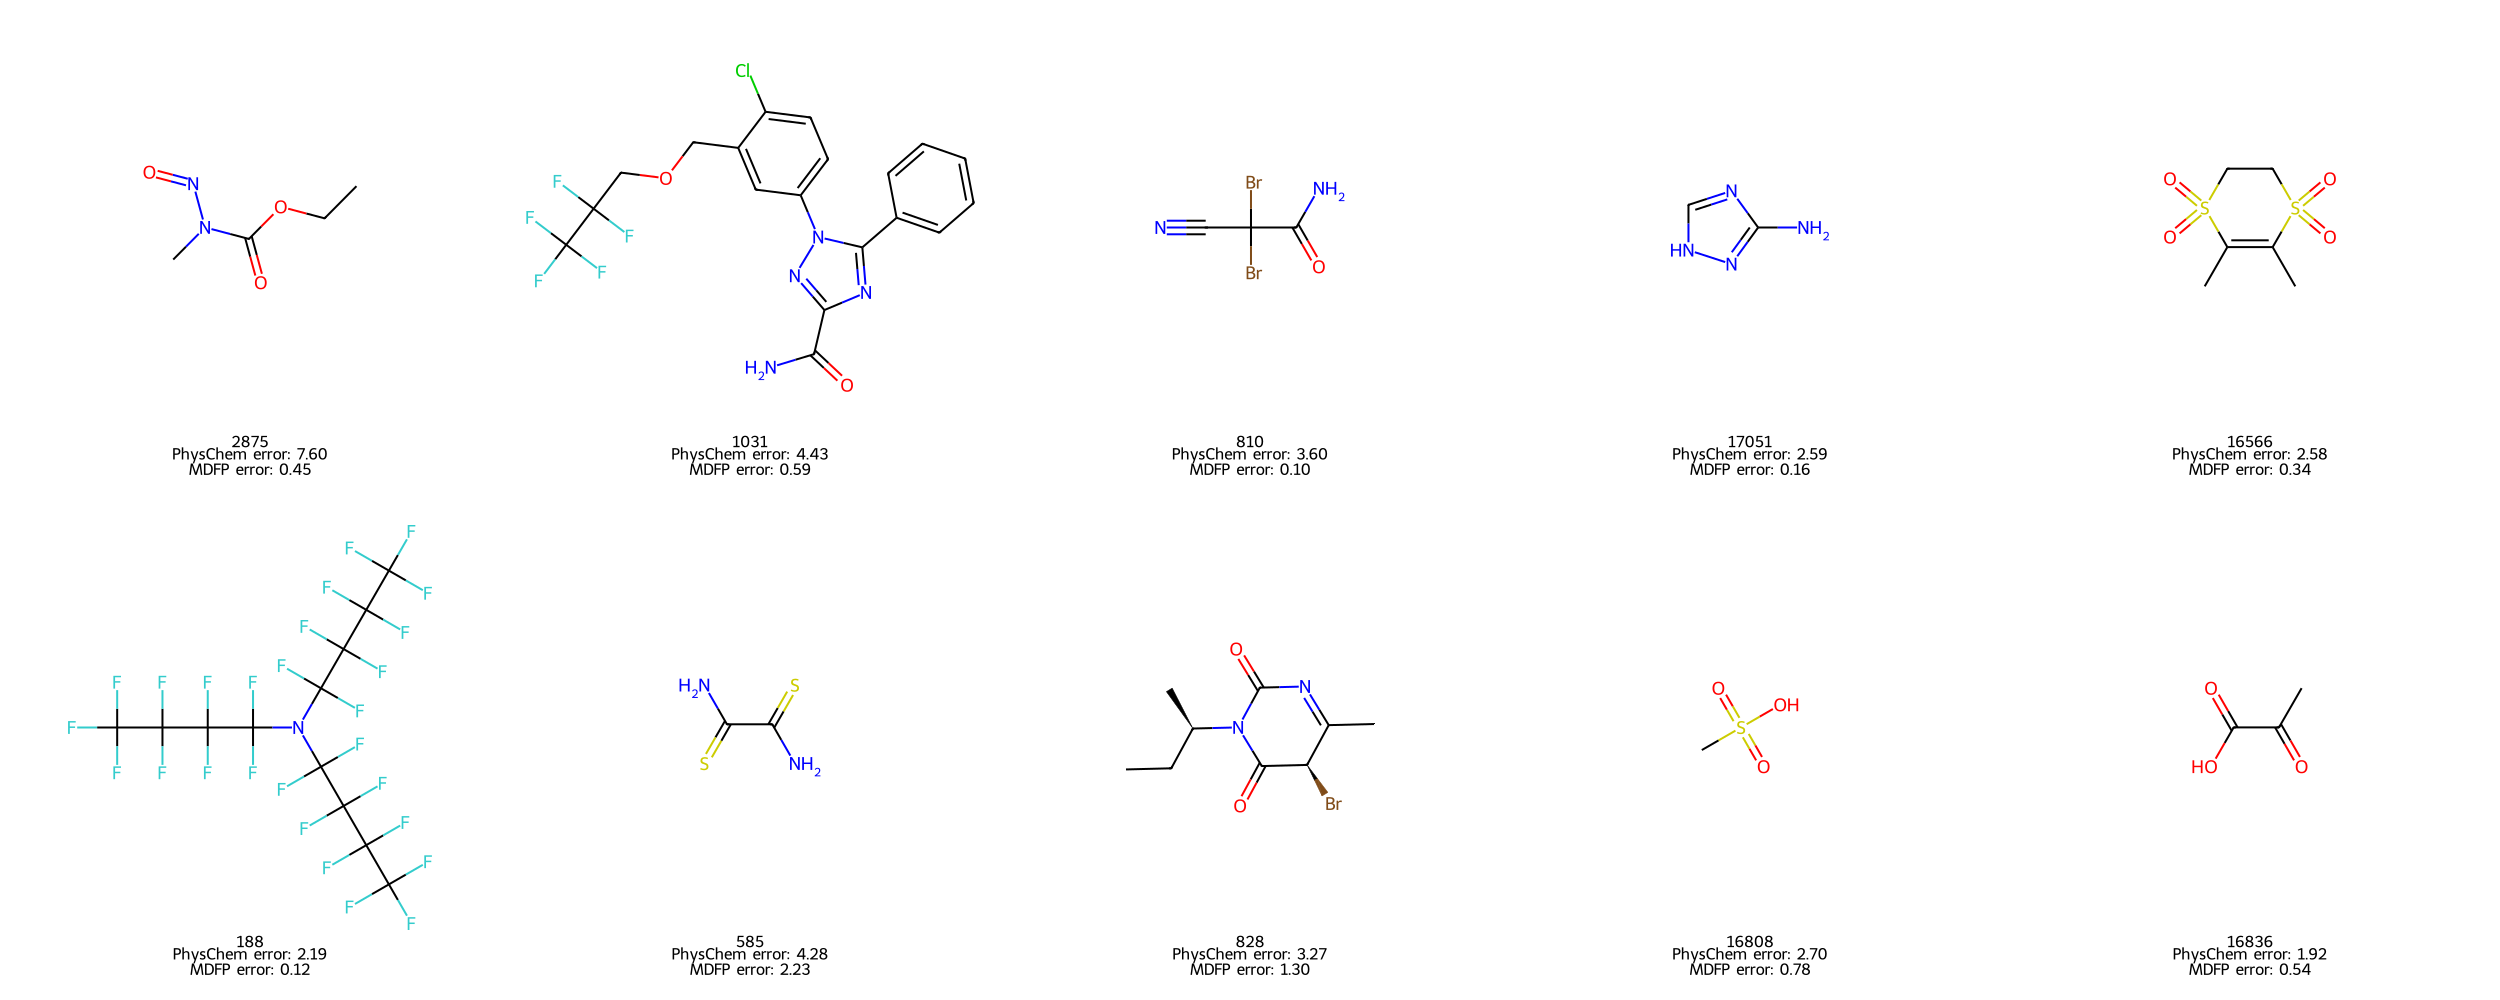

In [ ]:
#get biggest errors from this one
pred_list_xgboost_physchem_element_counts_flat = [item for sublist in pred_list_xgboost_physchem_element_counts for item in sublist]
ys_list_xgboost_physchem_element_counts_flat = [item for sublist in ys_list_xgboost_physchem_element_counts for item in sublist]
molregnos_xgboost_physchem_element_counts_flat = [item for sublist in molregnos_xgboost_physchem_element_counts for item in sublist]
df_results_xgboost_physchem_element_counts = pd.DataFrame({'Pred_Physchem': pred_list_xgboost_physchem_element_counts_flat, 'vp_log10_pa': ys_list_xgboost_physchem_element_counts_flat, 'molregno': molregnos_xgboost_physchem_element_counts_flat})
#average over molregno
df_results_xgboost_physchem_element_counts = df_results_xgboost_physchem_element_counts.groupby('molregno').mean()
df_results_xgboost_physchem_element_counts['vp_log10_pa'] = df_results_xgboost_physchem_element_counts['vp_log10_pa'].astype(float)
df_results_xgboost_physchem_element_counts['Pred_Physchem'] = df_results_xgboost_physchem_element_counts['Pred_Physchem'].astype(float)
df_results_xgboost_physchem_element_counts['error_PhysChem'] = abs(df_results_xgboost_physchem_element_counts['vp_log10_pa'] - df_results_xgboost_physchem_element_counts['Pred_Physchem'])

molregnos = df_worst_diff['molregno'].tolist()
error_physchem, error_mdfp = [], []
for mrno in molregnos:
    error_physchem.append(df_results_xgboost_physchem_element_counts.loc[mrno, 'error_PhysChem'])
    error_mdfp.append(df_results_avg.loc[mrno, 'error_MDFP'])
#sort these by error difference: highest first
error_diffs = [error_physchem[i] - error_mdfp[i] for i in range(len(molregnos))]
#sort error_physchem, error_mdfp, molregnos, mols_2D by error_diffs
error_physchem = [x for _, x in sorted(zip(error_diffs, error_physchem), reverse=True)]
error_mdfp = [x for _, x in sorted(zip(error_diffs, error_mdfp), reverse=True)]
molregnos = [x for _, x in sorted(zip(error_diffs, molregnos), reverse=True)]
mols_2D = [x for _, x in sorted(zip(error_diffs, mols_2D), reverse=True)]


img = Draw.MolsToGridImage(mols_2D, molsPerRow=5, subImgSize=(500, 500), legends=[f'{mrno}\nPhysChem error: {error_physchem[i]:.2f}\nMDFP error: {error_mdfp[i]:.2f}' for i, mrno in enumerate(molregnos)])
img

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_duplicate_correlation_single(df, combination,drop_exact_duplicates_decimals=None):
    df1 = df[df['source'] == combination[0]]
    df2 = df[df['source'] == combination[1]]

    # Get overlapping inchikeys
    inchikeys_source1 = df1['inchikey'].unique()
    inchikeys_source2 = df2['inchikey'].unique()
    inchikeys_overlap = list(set(inchikeys_source1).intersection(inchikeys_source2))

    # Get duplicates
    df1_duplicates = df1[df1['inchikey'].isin(inchikeys_overlap)]
    df2_duplicates = df2[df2['inchikey'].isin(inchikeys_overlap)]

    # Drop duplicates
    df1_duplicates = df1_duplicates.drop_duplicates(subset=['inchikey'])
    df2_duplicates = df2_duplicates.drop_duplicates(subset=['inchikey'])

    # Sort by inchikey
    df_subset_duplicates_source1 = df1_duplicates.sort_values(by=['inchikey'])
    df_subset_duplicates_source2 = df2_duplicates.sort_values(by=['inchikey'])

    # Drop exact duplicates
    if drop_exact_duplicates_decimals is not None:
        df_subset_duplicates_source1 = df_subset_duplicates_source1.round(decimals=drop_exact_duplicates_decimals)
        df_subset_duplicates_source2 = df_subset_duplicates_source2.round(decimals=drop_exact_duplicates_decimals)

        vals_1 = df_subset_duplicates_source1['log10_VP_Pa'].values
        vals_2 = df_subset_duplicates_source2['log10_VP_Pa'].values
        #get absolute differences
        diff_abs = abs(vals_1 - vals_2)

        treshold = 10**-drop_exact_duplicates_decimals
        exactly_same = diff_abs[diff_abs < treshold]
        #get indices of these
        indices = [i for i, v in enumerate(diff_abs) if v in exactly_same]
        #get inchikeys of these
        inchikeys = df_subset_duplicates_source1['inchikey'].values
        inchikeys = [inchikeys[i] for i in indices]
        #drop these from both
        df_subset_duplicates_source1 = df_subset_duplicates_source1[~df_subset_duplicates_source1['inchikey'].isin(inchikeys)]
        df_subset_duplicates_source2 = df_subset_duplicates_source2[~df_subset_duplicates_source2['inchikey'].isin(inchikeys)]

    # Get minimum and maximum for the plots
    minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
    maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())

    # Create a single plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot
    ax.scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
    ax.set_xlabel(combination[0])
    ax.set_ylabel(combination[1])

    # Make square
    ax.set_aspect('equal', 'box')

    # Add diagonal line
    ax.plot([-20, 10], [-20, 10], color='black')

    # Add dashed lines at 1 log unit difference
    ax.plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
    ax.plot([-21, 9], [-20, 10], color='black', linestyle='dashed')

    # Add dashed lines at 2 log unit difference
    ax.plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
    ax.plot([-22, 8], [-20, 10], color='black', linestyle='dotted')

    # Add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    from scipy.stats import pearsonr, spearmanr, kendalltau

    # Remove nan values
    df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
    df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()

    # Calculate metrics
    mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
    r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])

    # Also get: fraction exactly the same (diff smaller than 0.01), fraction within 0.3 log unit,
    # fraction within 1 log units and number of points with diff larger than 2 log units
    vals_1 = df_subset_duplicates_source1['log10_VP_Pa'].values
    vals_2 = df_subset_duplicates_source2['log10_VP_Pa'].values
    #np.abs not working, use some other way
    diff = vals_1 - vals_2
    diff_abs = abs(diff)

    fraction_exactly_same = len(diff_abs[diff_abs < 0.01]) / len(diff_abs)
    fraction_within_03 = len(diff_abs[diff_abs < 0.3]) / len(diff_abs)
    fraction_within_1 = len(diff_abs[diff_abs < 1]) / len(diff_abs)
    number_larger_2 = len(diff_abs[diff_abs > 2])

    # Add metrics and number of points to plot
    text_box = ax.text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {} points\nPearson: {:.3f}\nSpearman: {:.3f}\nKendall: {:.3f}'.format(mae, rmse, r2, len(df_subset_duplicates_source1), pearson[0], spearman[0], kendall[0]), transform=ax.transAxes, verticalalignment='top')
    text_box.set_bbox(dict(facecolor='white', edgecolor='black'))

    # Similar box in bottom right with fraction exactly the same, fraction within 0.3 log unit,
    # fraction within 1 log units and number of points with diff larger than 2 log units
    text_box = ax.text(0.50, 0.05, 'Fraction exactly same: {:.2f}\nFraction within 0.3: {:.2f}\nFraction within 1: {:.2f}\nNumber larger 2: {}'.format(fraction_exactly_same, fraction_within_03, fraction_within_1, number_larger_2), transform=ax.transAxes, verticalalignment='bottom')
    text_box.set_bbox(dict(facecolor='white', edgecolor='black'))

    ax.grid()

    # Set limit
    ax.set_xlim(minimum - 2, maximum + 2)
    ax.set_ylim(minimum - 2, maximum + 2)

    plt.tight_layout()
    plt.show()


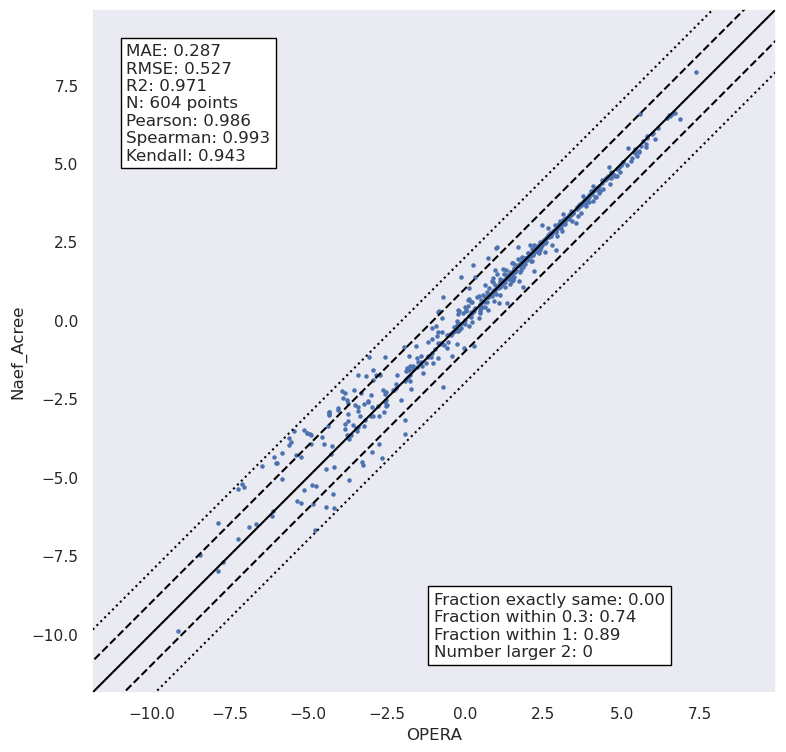

In [ ]:
df_opera_naef_acree = pd.read_csv('OPERA_plus_Naef_Acree_incl_overlap_descriptors.csv')
plot_duplicate_correlation_single(df_opera_naef_acree, ['OPERA', 'Naef_Acree'], drop_exact_duplicates_decimals=2)

In [ ]:
df_opera_naef_acree

,Unnamed: 0,standardized_smiles,log10_VP_Pa,inchikey,source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,CC(O)C(=O)O,1.035002,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,OPERA,9.449074,9.449074,1.185185,-1.231481,0.453936,...,0,0,0,0,0,0,0,0,0,0
1,1,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-1.134698,XZIDTOHMJBOSOX-UHFFFAOYSA-N,OPERA,10.567284,10.567284,0.030864,-1.187500,0.744344,...,0,0,0,0,0,0,0,0,0,0
2,2,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135498,FMMWHPNWAFZXNH-UHFFFAOYSA-N,OPERA,2.309074,2.309074,1.317945,1.317945,0.243454,...,0,0,0,0,0,0,0,0,0,0
3,4,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135000,FMMWHPNWAFZXNH-UHFFFAOYSA-N,Naef_Acree,2.309074,2.309074,1.317945,1.317945,0.243454,...,0,0,0,0,0,0,0,0,0,0
4,6,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-4.594099,ZPUCINDJVBIVPJ-UHFFFAOYSA-N,OPERA,12.296709,12.296709,0.097012,-0.408467,0.797936,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4400,6365,FC(F)Br,5.639000,GRCDJFHYVYUNHM-UHFFFAOYSA-N,Naef_Acree,10.250000,10.250000,1.937500,-2.354167,0.437677,...,0,0,0,0,0,0,0,0,0,0
4401,6366,F/C=C/C(F)(F)F,5.698000,CDOOAUSHHFGWSA-OWOJBTEDSA-N,Naef_Acree,10.729167,10.729167,0.479167,-4.505208,0.422449,...,0,0,0,0,0,0,0,0,0,0
4402,6367,C=O,5.710000,WSFSSNUMVMOOMR-UHFFFAOYSA-N,Naef_Acree,8.000000,8.000000,2.000000,2.000000,0.360624,...,0,0,0,0,0,0,0,0,0,0
4403,6368,FC(F)(F)OO[S@OH5](F)(F)(F)(F)F,5.821000,QYSKJQVQYGRSJM-UHFFFAOYSA-N,Naef_Acree,10.898472,10.898472,1.128472,-10.594807,0.407488,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_opera_naef_acree

,Unnamed: 0,standardized_smiles,log10_VP_Pa,inchikey,source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,CC(O)C(=O)O,1.035002,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,OPERA,9.449074,9.449074,1.185185,-1.231481,0.453936,...,0,0,0,0,0,0,0,0,0,0
1,1,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-1.134698,XZIDTOHMJBOSOX-UHFFFAOYSA-N,OPERA,10.567284,10.567284,0.030864,-1.187500,0.744344,...,0,0,0,0,0,0,0,0,0,0
2,2,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135498,FMMWHPNWAFZXNH-UHFFFAOYSA-N,OPERA,2.309074,2.309074,1.317945,1.317945,0.243454,...,0,0,0,0,0,0,0,0,0,0
3,4,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135000,FMMWHPNWAFZXNH-UHFFFAOYSA-N,Naef_Acree,2.309074,2.309074,1.317945,1.317945,0.243454,...,0,0,0,0,0,0,0,0,0,0
4,6,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-4.594099,ZPUCINDJVBIVPJ-UHFFFAOYSA-N,OPERA,12.296709,12.296709,0.097012,-0.408467,0.797936,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4400,6365,FC(F)Br,5.639000,GRCDJFHYVYUNHM-UHFFFAOYSA-N,Naef_Acree,10.250000,10.250000,1.937500,-2.354167,0.437677,...,0,0,0,0,0,0,0,0,0,0
4401,6366,F/C=C/C(F)(F)F,5.698000,CDOOAUSHHFGWSA-OWOJBTEDSA-N,Naef_Acree,10.729167,10.729167,0.479167,-4.505208,0.422449,...,0,0,0,0,0,0,0,0,0,0
4402,6367,C=O,5.710000,WSFSSNUMVMOOMR-UHFFFAOYSA-N,Naef_Acree,8.000000,8.000000,2.000000,2.000000,0.360624,...,0,0,0,0,0,0,0,0,0,0
4403,6368,FC(F)(F)OO[S@OH5](F)(F)(F)(F)F,5.821000,QYSKJQVQYGRSJM-UHFFFAOYSA-N,Naef_Acree,10.898472,10.898472,1.128472,-10.594807,0.407488,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#same analysis, with morgen fingerprints (ECFP4)
#first, get the morgen fingerprints for the molecules
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
m1 = Chem.MolFromSmiles('c1ccccn1')
m2 = Chem.MolFromSmiles('c1ccco1')
def fp_as_array(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    arr = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr
fp_as_array(m1)
print(len(fp_as_array(m1)))

1024


In [ ]:
from xgboost import XGBRegressor
preds_xgboost_ecfp4, ys_xgboost_ecfp4, molregnos_xgboost_ecfp4 = [],[],[]
for i in range(10):
    train = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_'+str(i)+'.csv')
    test = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_'+str(i)+'.csv')
    train['morgan'] = train['molblock'].apply(lambda x: fp_as_array(Chem.MolFromMolBlock(x)))
    test['morgan'] = test['molblock'].apply(lambda x: fp_as_array(Chem.MolFromMolBlock(x)))
    morgan_xgb = XGBRegressor()
    morgan_xgb.fit(np.array([x for x in train.morgan.values]),train.vp_log10_pa.values)
    morgan_pred = morgan_xgb.predict(np.array([x for x in test.morgan.values]))
    morgan_ys = test.vp_log10_pa
    molregnos = test.molregno
    print('RMSE:', mean_squared_error(morgan_ys, morgan_pred, squared=False))
    preds_xgboost_ecfp4.append(morgan_pred)
    ys_xgboost_ecfp4.append(morgan_ys)
    molregnos_xgboost_ecfp4.append(molregnos)


RMSE: 1.7210943157676961
RMSE: 1.8613013766182442
RMSE: 1.8446697397910534
RMSE: 1.5137232549454798
RMSE: 1.5957891307949272
RMSE: 1.6754440734012883
RMSE: 1.662025758342979
RMSE: 1.6583718454322898
RMSE: 1.7224833091299132
RMSE: 1.8456513539292854
